In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime,timedelta
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import time
import re
import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from itertools import product


import pickle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from itertools import product
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics import roc_auc_score,roc_curve,auc, precision_score, recall_score, precision_recall_curve,fbeta_score
from mlxtend.plotting import plot_confusion_matrix

from copy import deepcopy
from beautifultable import BeautifulTable
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [215]:
movies_data=pd.read_csv(r'ZEE-data\zee-movies.dat',delimiter='::', encoding='ISO-8859-1')
ratings_data=pd.read_csv(r'ZEE-data\zee-ratings.dat',delimiter='::')
users_data=pd.read_csv(r'ZEE-data\zee-users.dat',delimiter='::')

In [216]:
##Variables with missing values
def check_missing_values(data):
    null_cols=data.isna().sum(axis=0).reset_index()
    null_cols.columns=['columns','null_counts']
    null_cols=null_cols.loc[null_cols.null_counts>0].sort_values('null_counts',ascending=False)

    null_cols['null_percent']=100*null_cols['null_counts']/len(data)
    null_cols.reset_index(drop=True,inplace=True)
    return null_cols


check_missing_values(users_data)
##no nulls in movies, users and ratings data

,columns,null_counts,null_percent


In [217]:
movies_data['release_date']=movies_data.Title.apply(lambda x:re.findall(r'\(([\d]+)\)',str(x))[0]).astype(int)
genres=movies_data.Genres.apply(lambda x:x.split('|')).explode().reset_index()
genres=genres.groupby(['index','Genres']).Genres.count().unstack().fillna(0)

movies_data=movies_data.merge(genres,how='left',left_index=True,right_index=True)

In [218]:
ratings_data.loc[:,'Timestamp']=ratings_data.Timestamp.apply(lambda x:datetime.fromtimestamp(x))
ratings_data['rated_year']=ratings_data.Timestamp.dt.year
ratings_data['rated_weeknum']=ratings_data.Timestamp.dt.week

ratings_data=ratings_data.merge(users_data,how='left',on='UserID')
ratings_data=ratings_data.merge(movies_data,how='left',left_on='MovieID',right_on='Movie ID')
ratings_data['yrs_bet_release_and_rated']=ratings_data.rated_year-ratings_data.release_date

ratings_data.rename({"Children's":"Children"
                    ,'Film-Noir':'Film_Noir'
                    ,'Sci-Fi':'Sci_Fi'},axis=1,inplace=True)

In [219]:
check_missing_values(ratings_data)
#no missing values in ratings dataset

,columns,null_counts,null_percent


In [220]:
ratings_data['Zip-code'].value_counts()
##dropping zip-code.. too many cardinality

94110         3802
60640         3430
98103         3204
95616         3079
02138         3019
              ... 
90732           20
954025          20
77565-2332      20
97838           20
14706           20
Name: Zip-code, Length: 3439, dtype: int64

In [221]:
ratings_data.drop(['Zip-code','Movie ID'],axis=1,inplace=True)

In [222]:
ratings_data

,UserID,MovieID,Rating,Timestamp,rated_year,rated_weeknum,Gender,Age,Occupation,Title,Genres,release_date,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,yrs_bet_release_and_rated
0,1,1193,5,2001-01-01 03:42:40,2001,1,F,1,10,One Flew Over the Cuckoo's Nest (1975),Drama,1975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26
1,1,661,3,2001-01-01 04:05:09,2001,1,F,1,10,James and the Giant Peach (1996),Animation|Children's|Musical,1996,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,1,914,3,2001-01-01 04:02:48,2001,1,F,1,10,My Fair Lady (1964),Musical|Romance,1964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,37
3,1,3408,4,2001-01-01 03:34:35,2001,1,F,1,10,Erin Brockovich (2000),Drama,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1,2355,5,2001-01-07 05:08:11,2001,1,F,1,10,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,2000-04-26 08:05:41,2000,17,M,25,6,Weekend at Bernie's (1989),Comedy,1989,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
1000205,6040,1094,5,2000-04-26 04:51:27,2000,17,M,25,6,"Crying Game, The (1992)",Drama|Romance|War,1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,8
1000206,6040,562,5,2000-04-26 04:49:06,2000,17,M,25,6,Welcome to the Dollhouse (1995),Comedy|Drama,1995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1000207,6040,1096,4,2000-04-26 07:50:48,2000,17,M,25,6,Sophie's Choice (1982),Drama,1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18


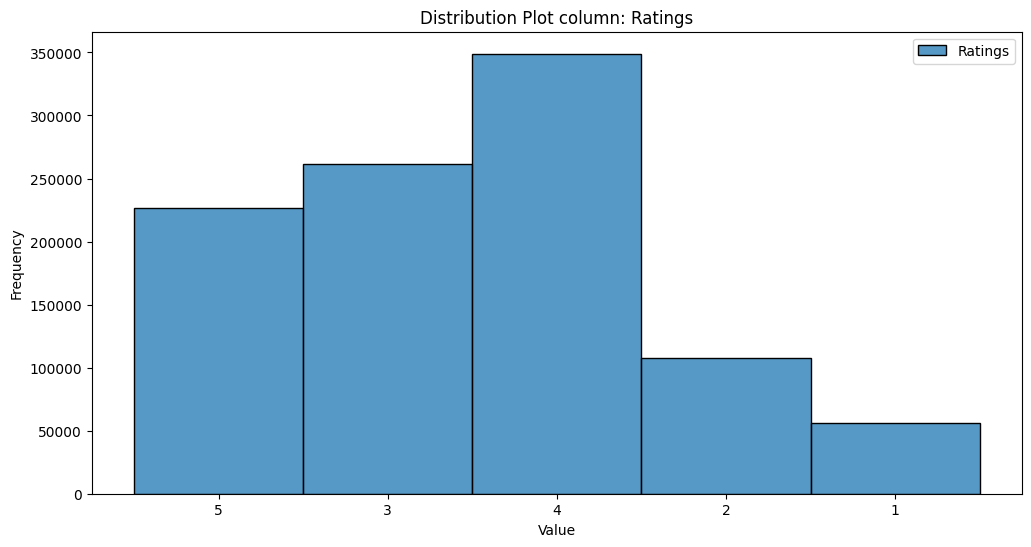

In [223]:
plt.figure(figsize=(12, 6))

sns.histplot(ratings_data.Rating.astype(str), label='{}'.format('Ratings'), palette='viridis')  

plt.title('Distribution Plot column: {}'.format('Ratings'))
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

=============== Gender-Rating ================



Gender      F       M
Rating               
1       13347   42827
2       24548   83009
3       62966  198231
4       87033  261938
5       58546  167764
chi2: 455.86073811141705 with p_value: 2.3485611329249177e-97
There is a statistically significant association between Gender and Rating.


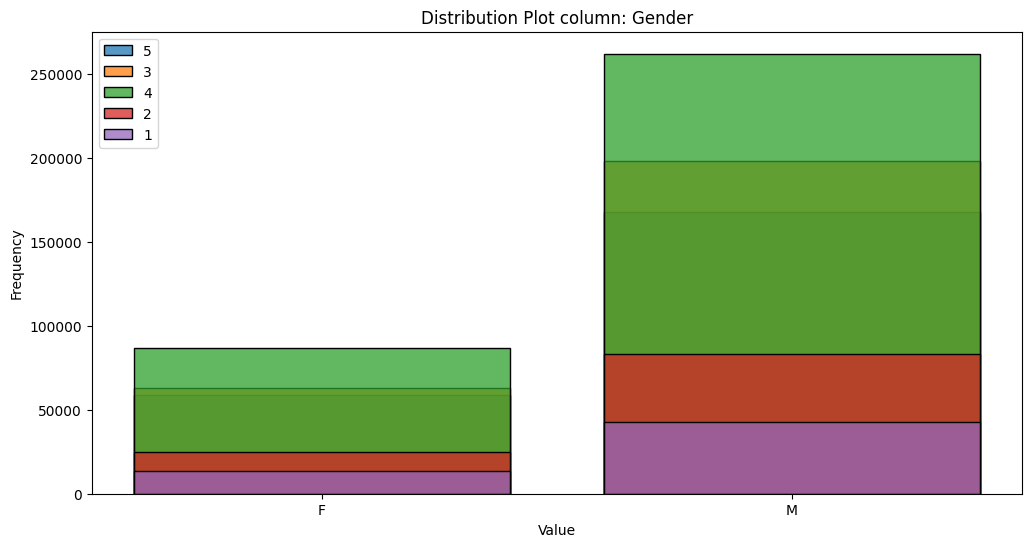

=============== Age-Rating ================



Age       1      18      25     35     45     50     56
Rating                                                 
1       2238  13063   23898   9067   3409   2948   1551
2       2983  22073   44817  20253   8437   5993   3001
3       6380  47601  104287  52990  22311  18465   9163
4       8808  60241  136824  71983  30334  26484  14297
5       6802  40558   85730  44710  19142  18600  10768
chi2: 5419.9415710815465 with p_value: 0.0
There is a statistically significant association between Age and Rating.


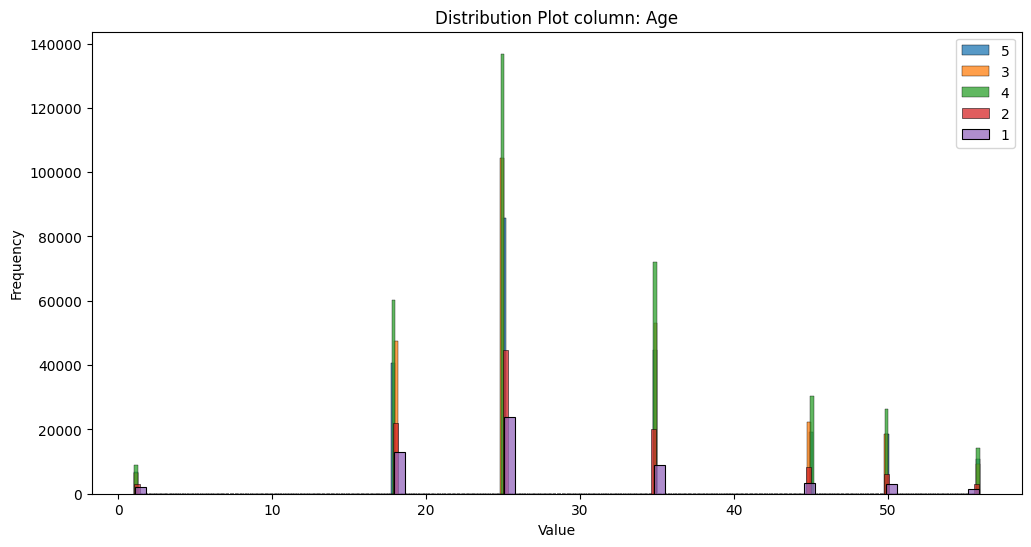

=============== Occupation-Rating ================



Occupation     0      1      2      3      4     5      6      7    8     9   \
Rating                                                                         
1            7892   4756   3062   1521   9004  1070   2046   5076  176   393   
2           14679   9054   5486   3083  15418  2552   3332  10978  292  1045   
3           35494  22361  12919   7958  33119  6446   9058  28054  820  3182   
4           44256  30577  16899  11236  43219  7127  13500  38273  929  4170   
5           28178  18603  11702   7825  30272  4655   9269  23044  489  2555   

Occupation    10    11     12    13     14    15     16     17    18    19  \
Rating                                                                       
1           2058  1337   2578   405   2345   887   2051   3351   583  1417   
2           2570  2056   5675  1176   5160  2271   4980   7193  1295  1835   
3           5392  4814  14382  3274  12696  5571  12355  19908  3655  399

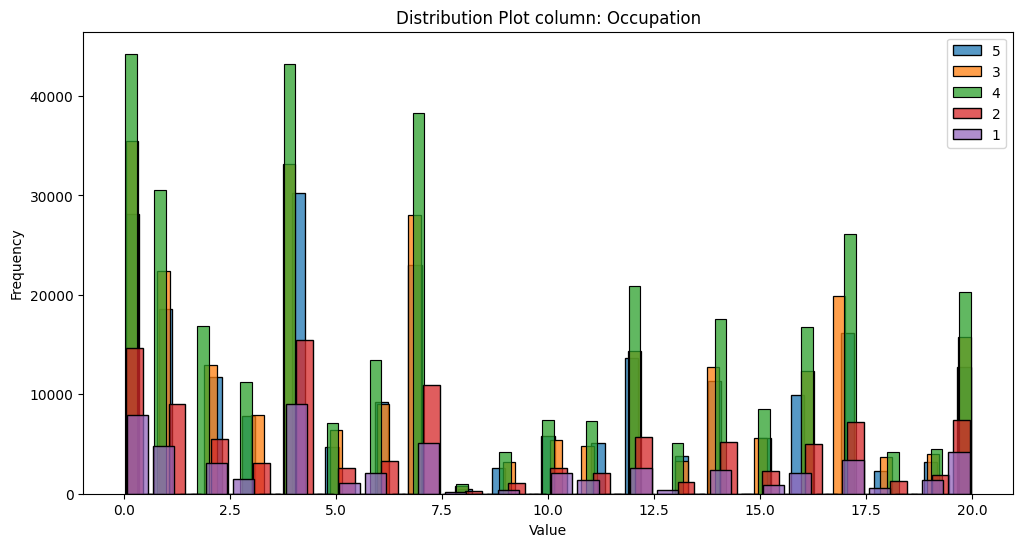

=============== rated_year-Rating ================



rated_year    2000   2001  2002  2003
Rating                               
1            51017   3549  1354   254
2            96021   8032  3114   390
3           234132  19311  6900   854
4           314230  25052  8502  1187
5           208775  12684  4183   668
chi2: 1383.5851308494402 with p_value: 4.81005603077088e-289
There is a statistically significant association between rated_year and Rating.


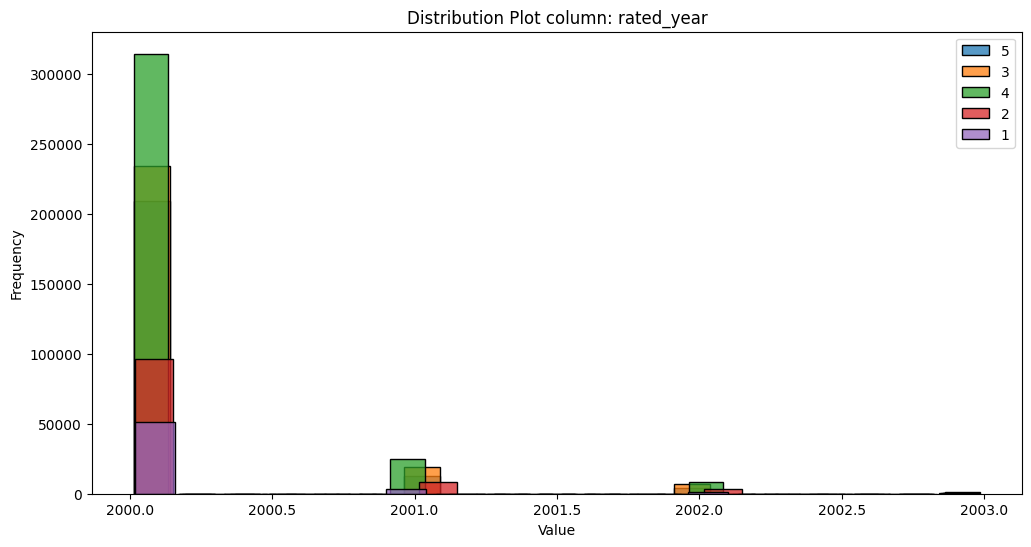

=============== release_date-Rating ================



release_date  1919  1920  1921  1922  1923  1925  1926  1927  1928  1929  \
Rating                                                                     
1                3     2     3    12     4    23    14     7     2     6   
2                3     3     5    10     2    15    24     5     0     5   
3               15     4    10    42     2    99    98    31     4    13   
4               18     7    28    78     6   203   165    77    14    14   
5                6     8    16    96     3   221   171   132     7     5   

release_date  1930  1931  1932  1933  1934  1935  1936  1937  1938  1939  \
Rating                                                                     
1               11    30    18    38    22    17    13    44    26    77   
2               13    52    29   109    28    26    27    71    40   150   
3               60   205   101   380   180   167   114   325   223   690   
4              148   463   140 

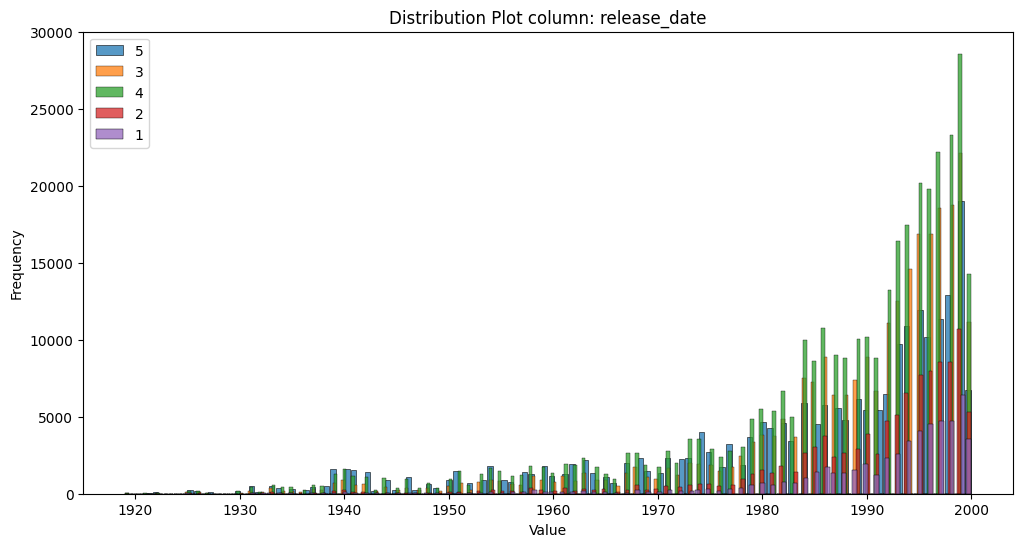

=============== rated_weeknum-Rating ================



rated_weeknum    1     2     3     4     5    6    7     8    9    10   11  \
Rating                                                                       
1               272   197   219   317   306  110  203   125   82  139  116   
2               855   562   535   579   485  221  410   362  342  266  244   
3              2184  1570  1202  1292  1132  591  776   922  747  633  450   
4              2810  2040  1577  1673  1414  983  878  1362  935  736  519   
5              1473  1058   899   906   709  585  444   794  457  349  261   

rated_weeknum   12   13   14   15   16    17    18    19    20    21    22  \
Rating                                                                       
1               68   74  264   87   85   574   871  1254  1024   956   922   
2              208  140  341  216  158  1418  1555  1790  1725  1664  2072   
3              602  371  816  439  330  3620  3692  4583  3718  4338  4989   
4     

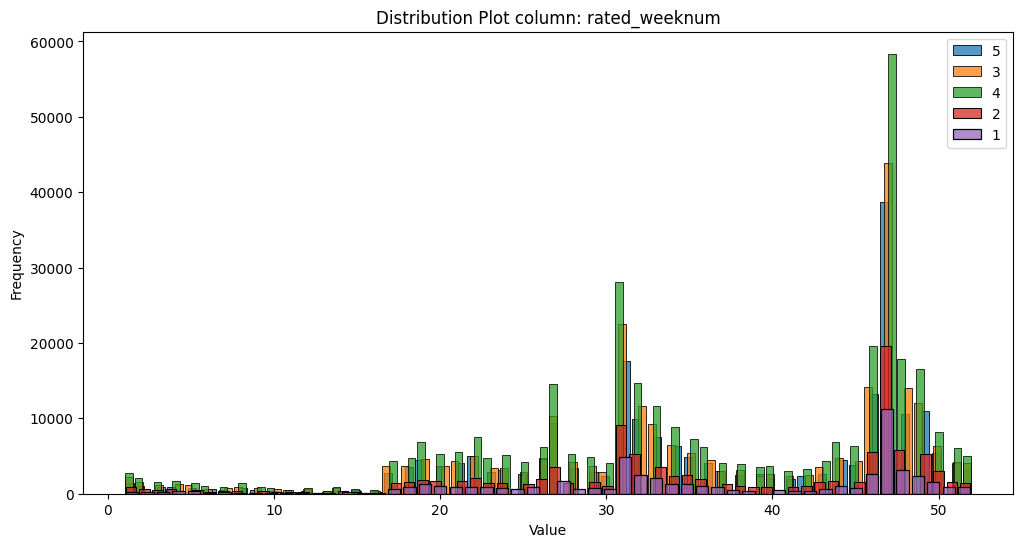

=============== Action-Rating ================



Action     0.0    1.0
Rating               
1        39643  16531
2        76125  31432
3       190469  70728
4       262392  86579
5       174123  52187
chi2: 2335.7483013476444 with p_value: 0.0
There is a statistically significant association between Action and Rating.


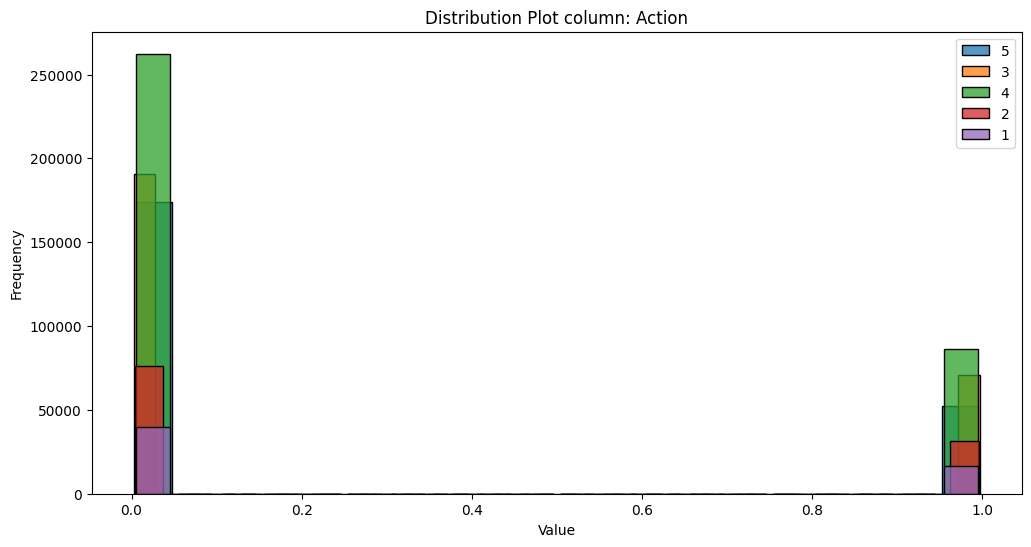

=============== Adventure-Rating ================



Adventure     0.0    1.0
Rating                  
1           47680   8494
2           90916  16641
3          223330  37867
4          304628  44343
5          199702  26608
chi2: 1483.710505057853 with p_value: 0.0
There is a statistically significant association between Adventure and Rating.


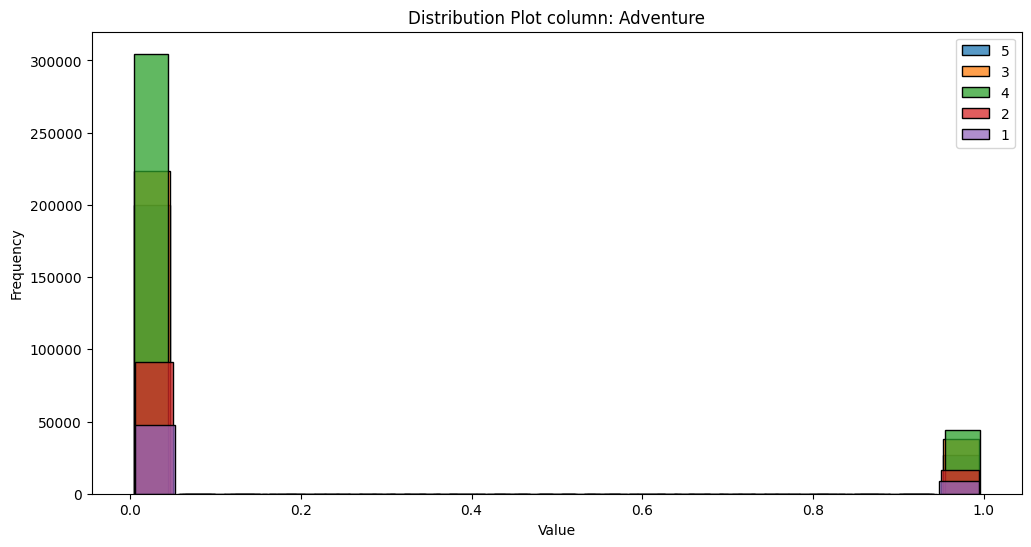

=============== Animation-Rating ================



Animation     0.0    1.0
Rating                  
1           54077   2097
2          103970   3587
3          250224  10973
4          333130  15841
5          215515  10795
chi2: 458.717410167822 with p_value: 5.6648006882804945e-98
There is a statistically significant association between Animation and Rating.


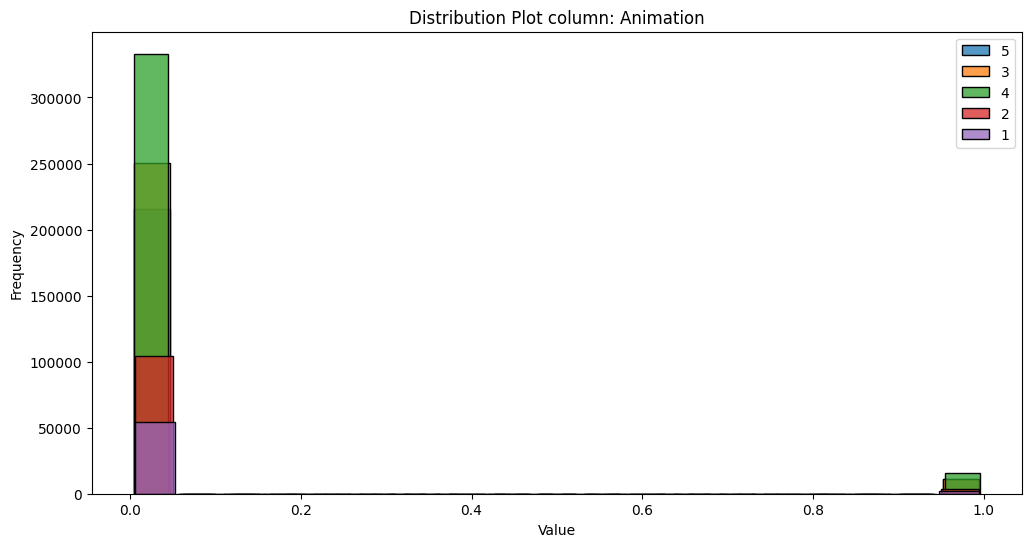

=============== Children-Rating ================



Children     0.0    1.0
Rating                 
1          50299   5875
2          98920   8637
3         240801  20396
4         325267  23704
5         212736  13574
chi2: 1720.3724808969591 with p_value: 0.0
There is a statistically significant association between Children and Rating.


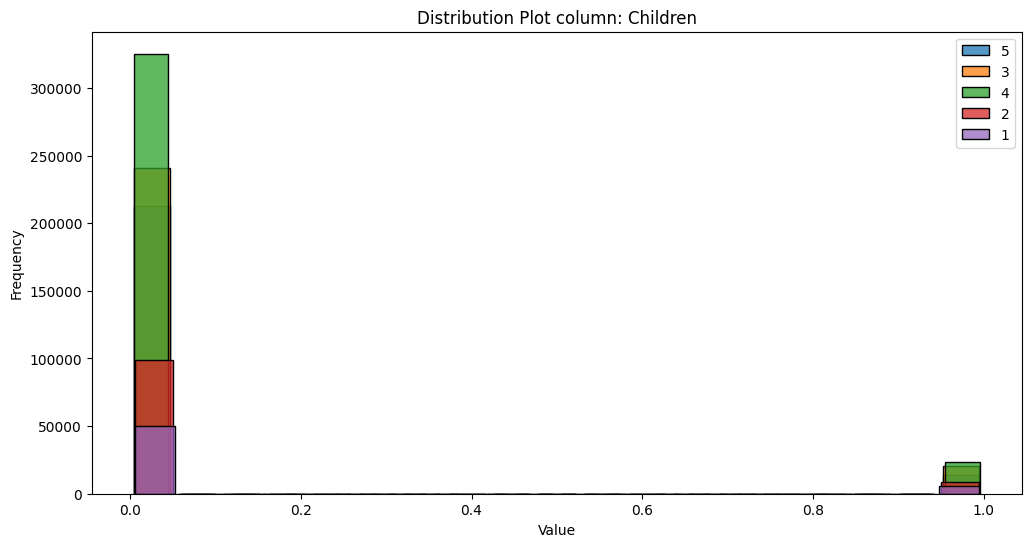

=============== Comedy-Rating ================



Comedy     0.0     1.0
Rating                
1        34558   21616
2        66484   41073
3       164251   96946
4       225556  123415
5       152780   73530
chi2: 1739.562594245329 with p_value: 0.0
There is a statistically significant association between Comedy and Rating.


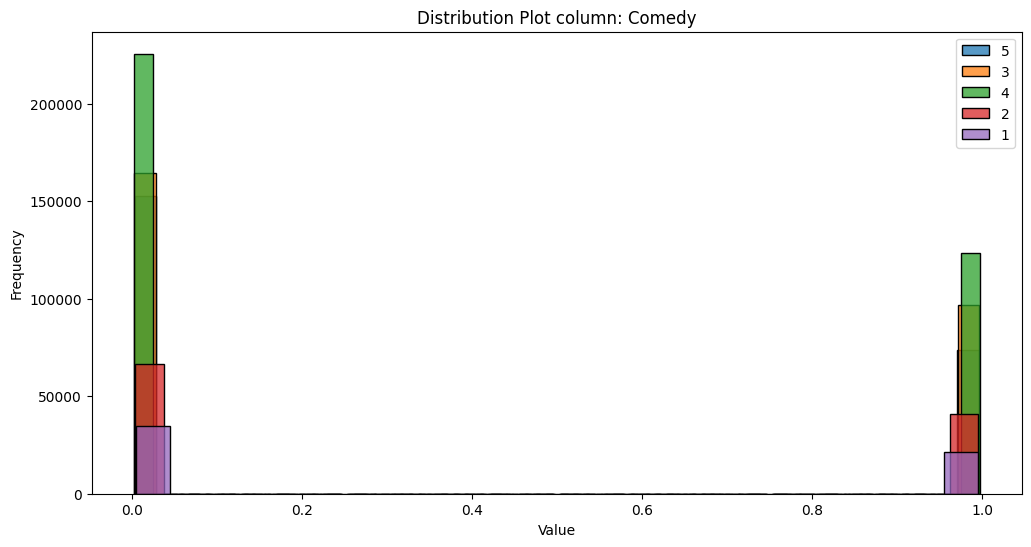

=============== Crime-Rating ================



Crime      0.0    1.0
Rating               
1        52955   3219
2       100124   7433
3       241655  19542
4       320517  28454
5       205417  20893
chi2: 1142.9251440066153 with p_value: 3.7558259838917927e-246
There is a statistically significant association between Crime and Rating.


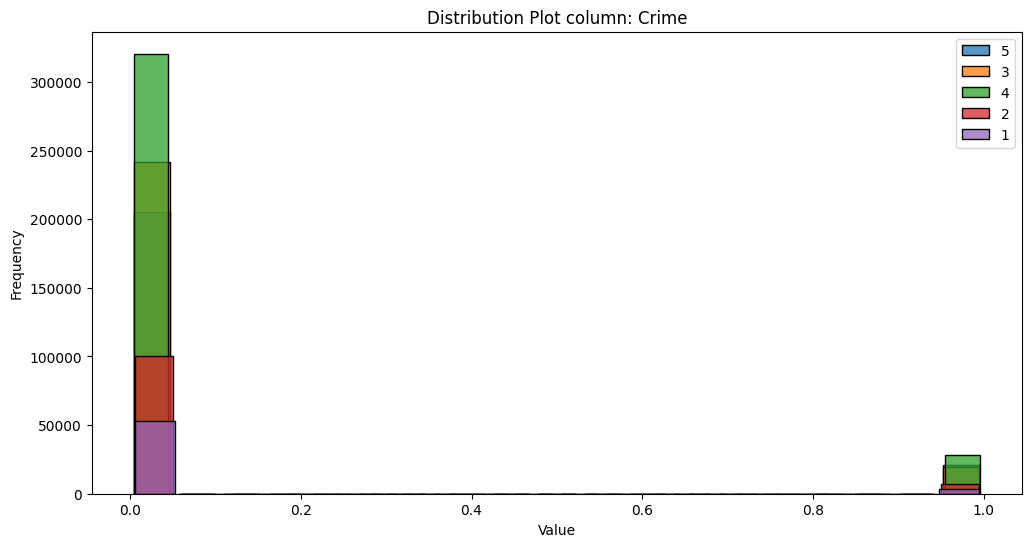

=============== Documentary-Rating ================



Documentary     0.0   1.0
Rating                   
1             55903   271
2            107080   477
3            259751  1446
4            345939  3032
5            223626  2684
chi2: 898.3084979138507 with p_value: 3.873909835368012e-193
There is a statistically significant association between Documentary and Rating.


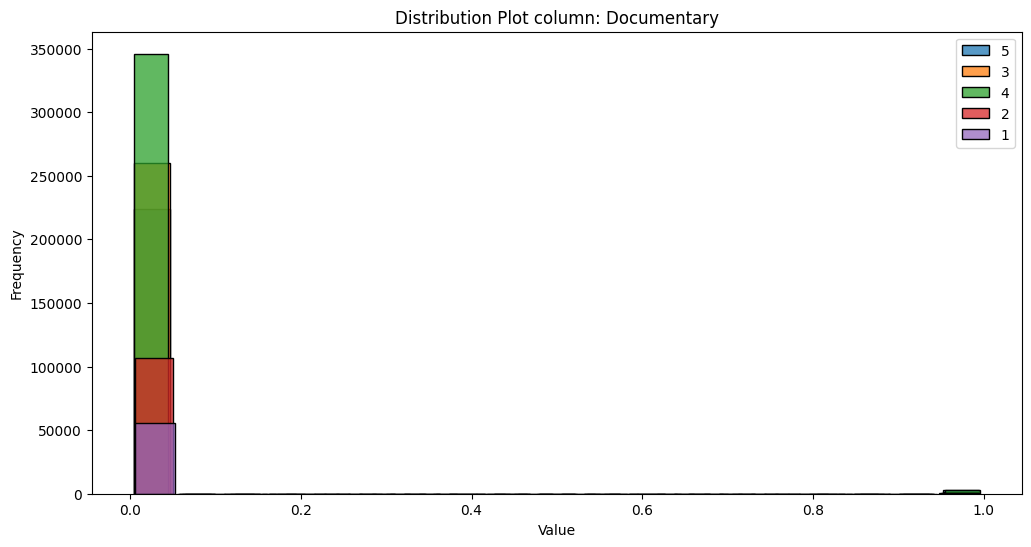

=============== Drama-Rating ================



Drama      0.0     1.0
Rating                
1        44060   12114
2        78403   29154
3       176376   84821
4       217160  131811
5       129681   96629
chi2: 15033.979340497073 with p_value: 0.0
There is a statistically significant association between Drama and Rating.


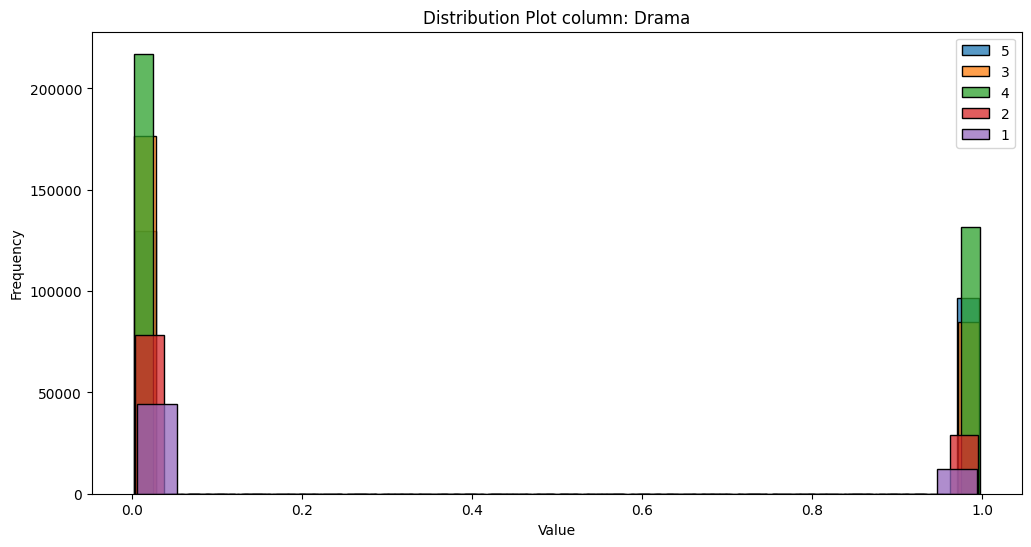

=============== Fantasy-Rating ================



Fantasy     0.0    1.0
Rating                
1         53807   2367
2        102828   4729
3        250706  10491
4        337246  11725
5        219321   6989
chi2: 609.770918392482 with p_value: 1.1898337702628425e-130
There is a statistically significant association between Fantasy and Rating.


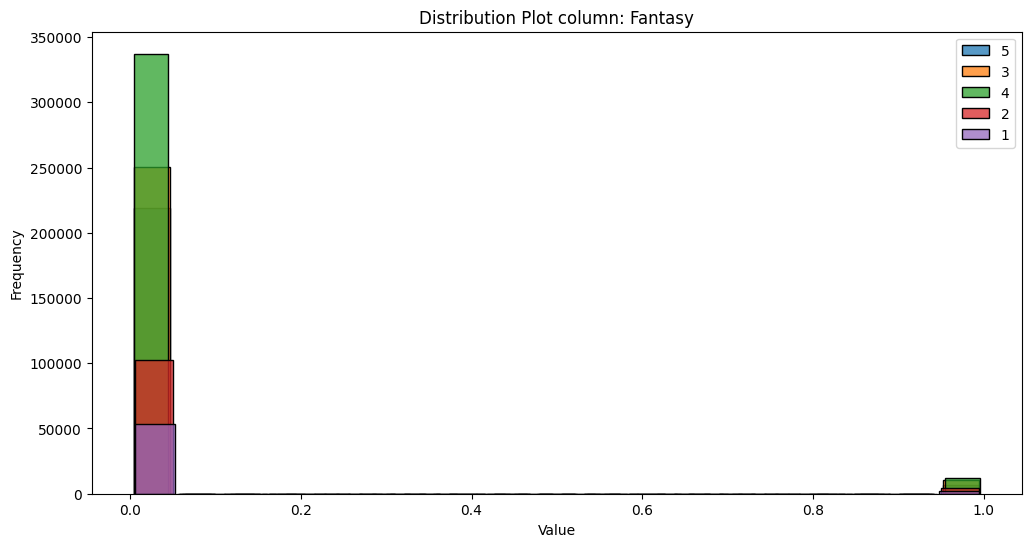

=============== Film_Noir-Rating ================



Film_Noir     0.0   1.0
Rating                 
1           55908   266
2          106728   829
3          257973  3224
4          342082  6889
5          219257  7053
chi2: 3897.173196388609 with p_value: 0.0
There is a statistically significant association between Film_Noir and Rating.


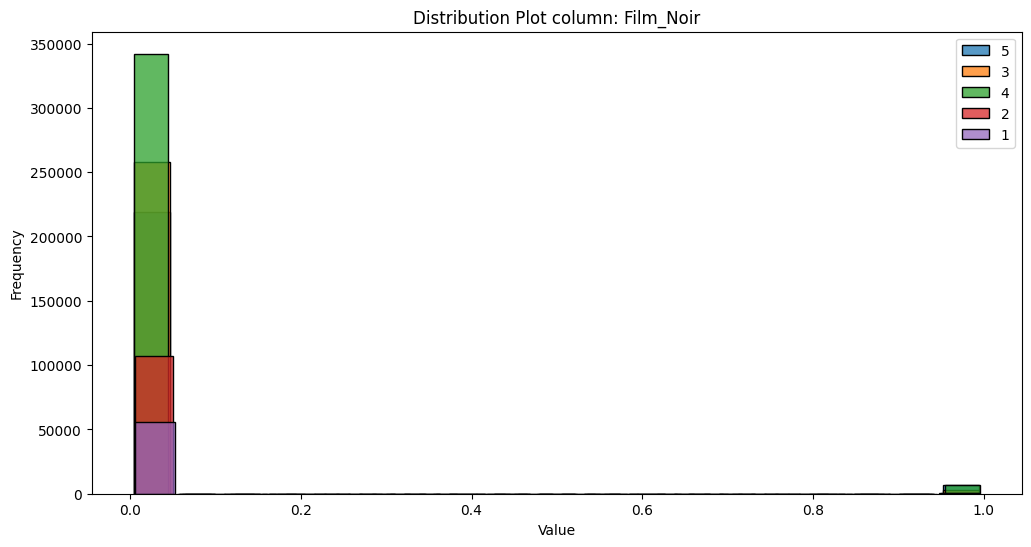

=============== Horror-Rating ================



Horror     0.0    1.0
Rating               
1        47246   8928
2        95587  11970
3       239797  21400
4       327045  21926
5       214148  12162
chi2: 9952.568680724316 with p_value: 0.0
There is a statistically significant association between Horror and Rating.


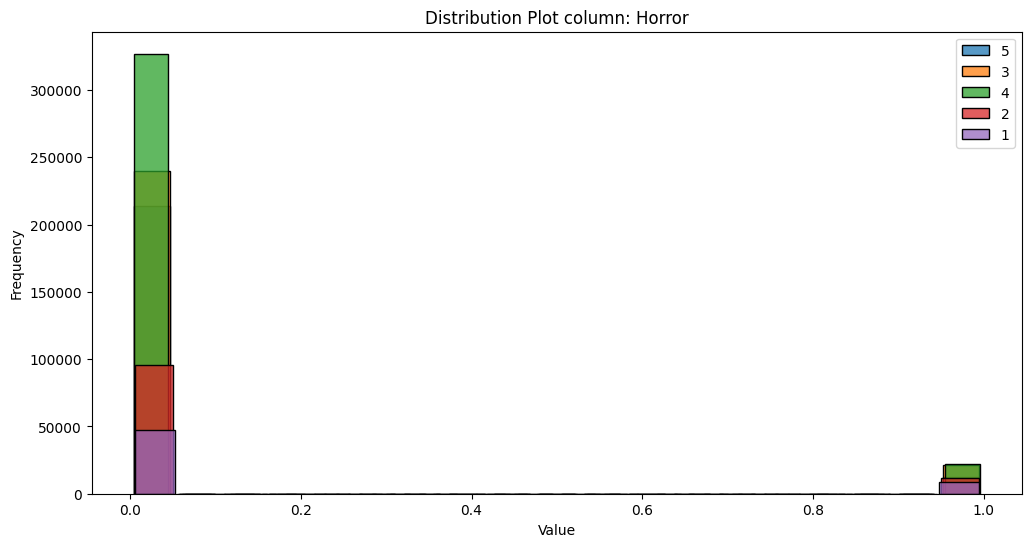

=============== Musical-Rating ================



Musical     0.0    1.0
Rating                
1         54081   2093
2        103778   3779
3        250647  10550
4        334355  14616
5        215815  10495
chi2: 279.32065338382563 with p_value: 3.1222120724375595e-59
There is a statistically significant association between Musical and Rating.


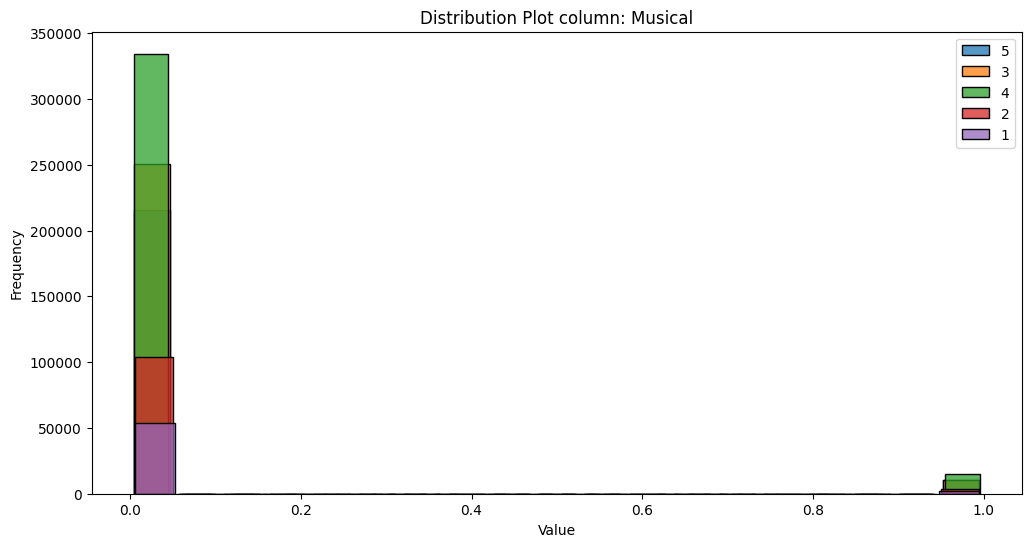

=============== Mystery-Rating ================



Mystery     0.0    1.0
Rating                
1         54439   1735
2        103531   4026
3        251080  10117
4        334710  14261
5        216271  10039
chi2: 267.88793496244256 with p_value: 9.099709191404459e-57
There is a statistically significant association between Mystery and Rating.


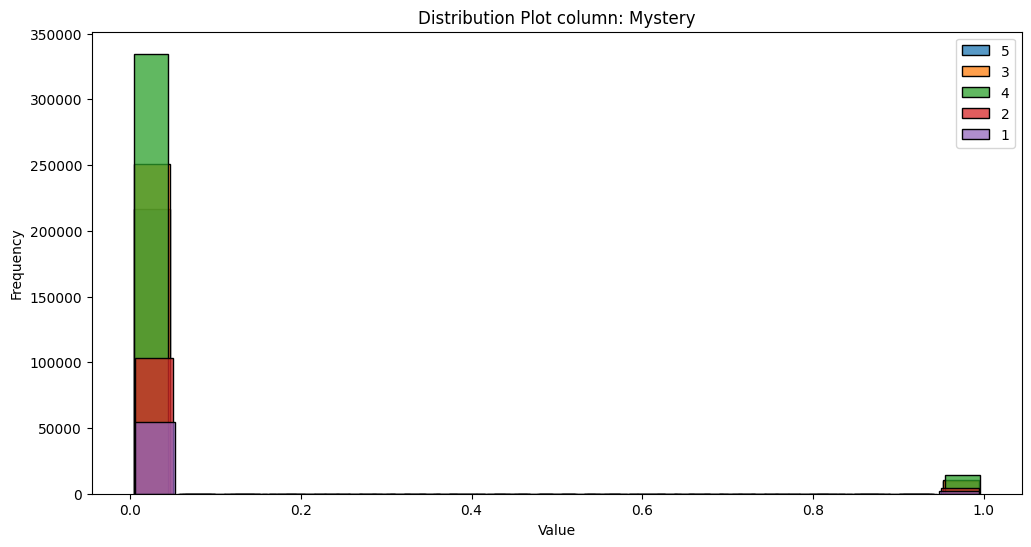

=============== Romance-Rating ================



Romance     0.0    1.0
Rating                
1         49827   6347
2         92308  15249
3        220769  40428
4        295531  53440
5        194251  32059
chi2: 819.7719490800473 with p_value: 4.0040949250362126e-176
There is a statistically significant association between Romance and Rating.


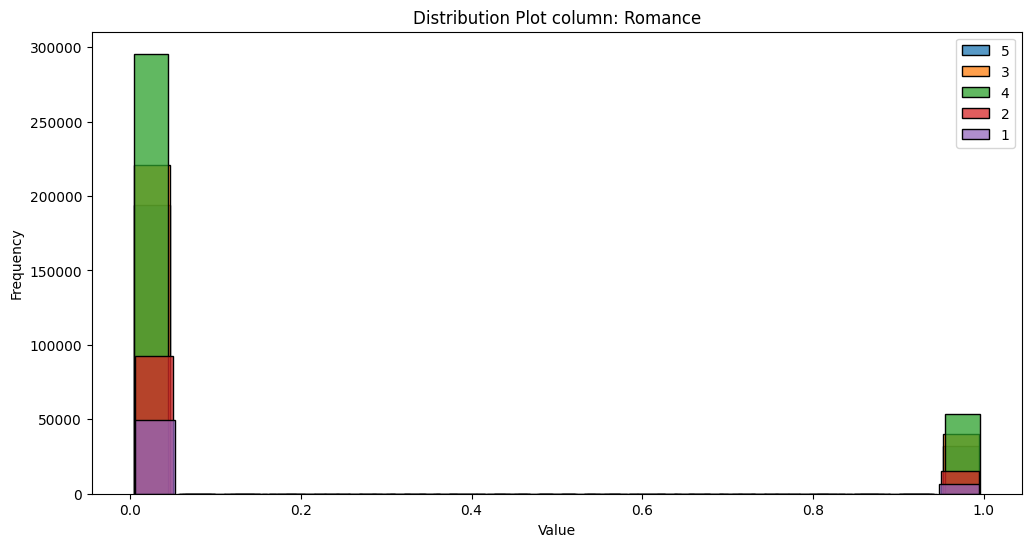

=============== Sci_Fi-Rating ================



Sci_Fi     0.0    1.0
Rating               
1        45122  11052
2        87404  20153
3       218305  42892
4       298215  50756
5       193869  32441
chi2: 2190.0358146668705 with p_value: 0.0
There is a statistically significant association between Sci_Fi and Rating.


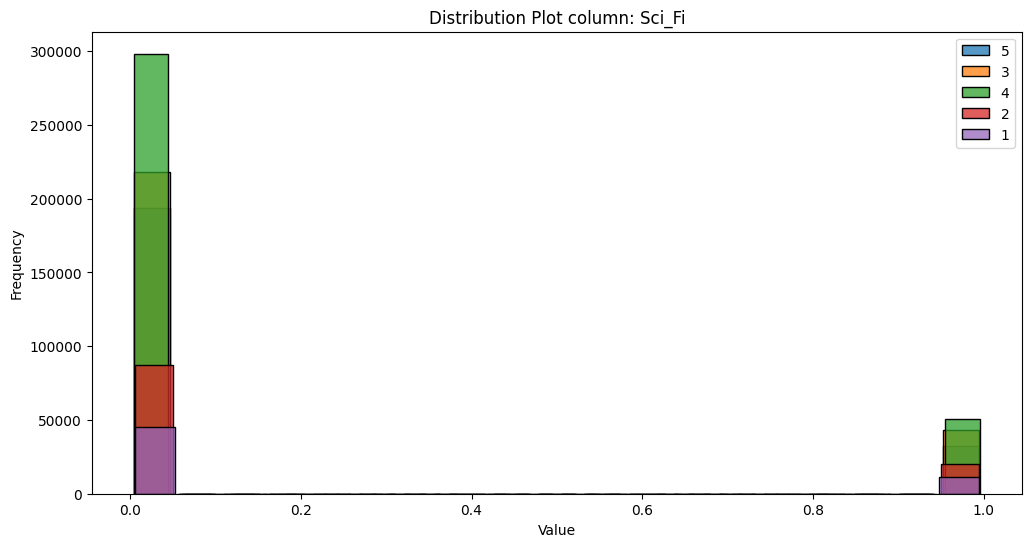

=============== Thriller-Rating ================



Thriller     0.0    1.0
Rating                 
1          46093  10081
2          86301  21256
3         211070  50127
4         282163  66808
5         184902  41408
chi2: 164.1791623974054 with p_value: 1.8556430254243173e-34
There is a statistically significant association between Thriller and Rating.


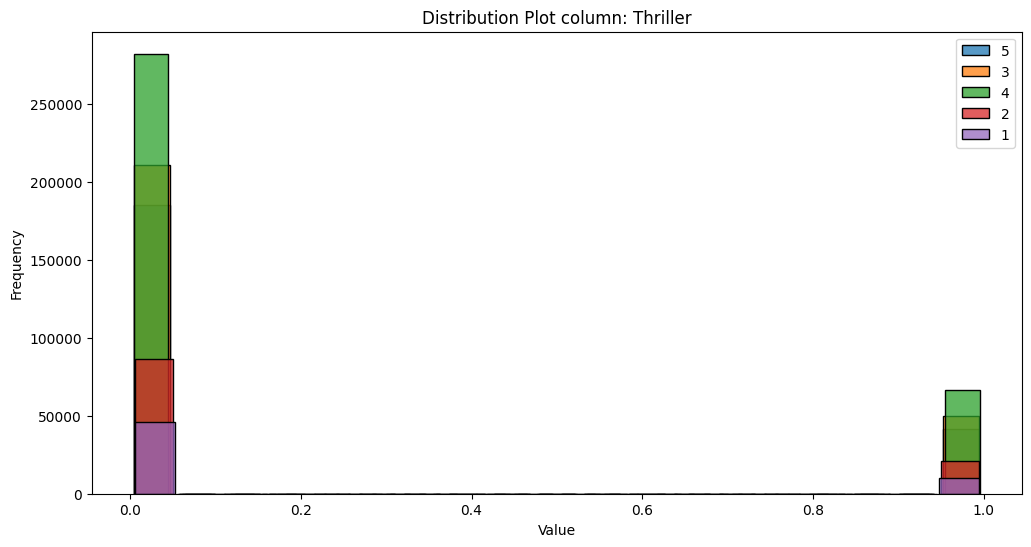

=============== War-Rating ================



War        0.0    1.0
Rating               
1        53727   2447
2       102703   4854
3       247513  13684
4       324852  24119
5       202887  23423
chi2: 6876.208909124303 with p_value: 0.0
There is a statistically significant association between War and Rating.


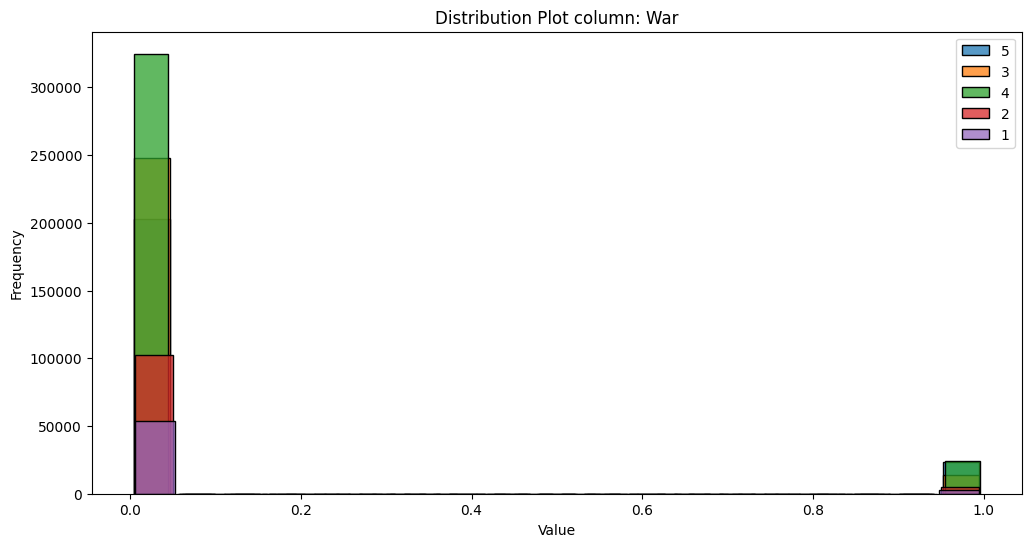

=============== Western-Rating ================



Western     0.0   1.0
Rating               
1         55104  1070
2        105612  1945
3        255840  5357
4        341625  7346
5        221345  4965
chi2: 63.649034098819655 with p_value: 4.954344491522561e-13
There is a statistically significant association between Western and Rating.


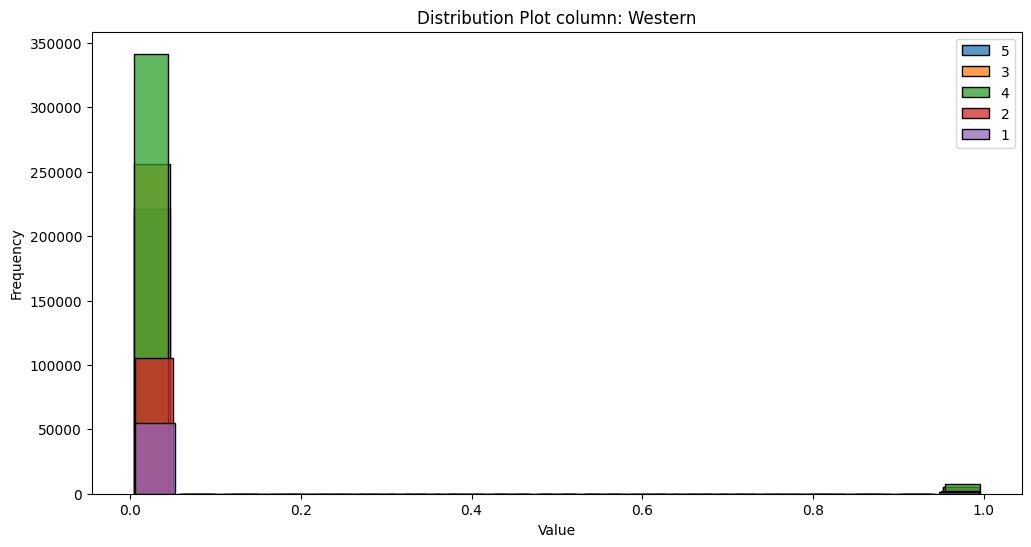

=============== yrs_bet_release_and_rated-Rating ================
            count       mean        std  min  25%   50%   75%   max
Rating                                                            
1        56174.0   9.255705  10.789604  0.0  3.0   6.0  12.0  81.0
2       107557.0  10.106009  10.974151  0.0  3.0   6.0  14.0  81.0
3       261197.0  12.154267  13.050008  0.0  3.0   8.0  16.0  82.0
4       348971.0  13.916506  14.638091  0.0  4.0   9.0  18.0  81.0
5       226310.0  16.760855  16.547009  0.0  4.0  11.0  24.0  82.0


                 sum_sq         df            F  PR(>F)
C(Rating)  5.185714e+06        4.0  6460.392324     0.0
Residual   2.007143e+08  1000204.0          NaN     NaN
There is a statistically significant difference between the mean yrs_bet_release_and_rated across the groups in Rating.


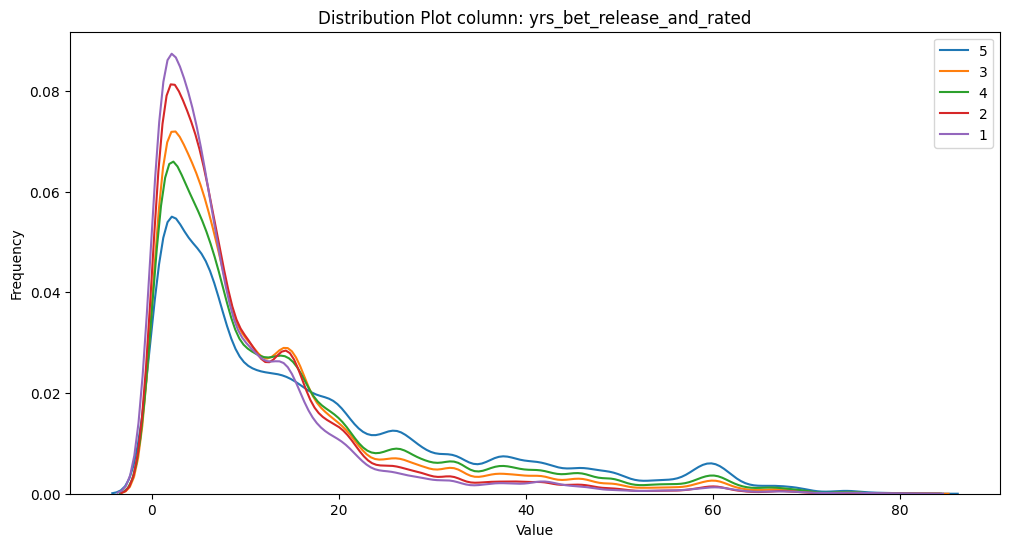

In [224]:
#Hypothesis test

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

target_var='Rating'
categorical_vars=['Gender','Age','Occupation','rated_year'
                  ,'release_date','rated_weeknum','Action','Adventure','Animation','Children'
                  ,'Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror'
                  ,'Musical','Mystery','Romance','Sci_Fi','Thriller','War','Western']
numerical_vars=['yrs_bet_release_and_rated']

def anova_lm_test(data, col, tar):
    # Perform ANOVA (Analysis of Variance)
    formula = f'{col} ~ C({tar})'
    model = smf.ols(formula, data=data).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    
    print(anova_table)
    
    p_value = anova_table["PR(>F)"][0]
    ff=anova_table["F"][0]
    if p_value < 0.05:
        print(f'There is a statistically significant difference between the mean {col} across the groups in {tar}.')
        return ff,1
    else:
        print('There is no sufficient evidence of a significant difference between the means across the groups.')
        return ff,0
    
    
def cat_chi2test(data,col,tar):

    contingency_table=pd.crosstab(data[tar],data[col])
    print(contingency_table)

    chi2,p,dof,expected=stats.chi2_contingency(contingency_table)
    print('chi2: {} with p_value: {}'.format(chi2,p))
    if p<0.05:
        print('There is a statistically significant association between {} and {}.'.format(col,tar))
        return chi2,1
    else:
        print('There is no sufficient evidence of a significant association between {} and {}.'.format(col,tar))
        return chi2,0

def dist_cat_plot(d1,cols,tar):
    for col in cols:
        plt.figure(figsize=(12, 6))

        for label in d1[tar].unique():
            
            sns.histplot(d1.loc[d1[tar]==label,col], label='{}'.format(label), palette='viridis', multiple='dodge', shrink=0.8)  

        plt.title('Distribution Plot column: {}'.format(col))
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()

        # Show plot
        plt.show()
        
def dist_plot(d1,cols,tar):
    for col in cols:
        plt.figure(figsize=(12, 6))

        for label in d1[tar].unique():
            sns.kdeplot(d1.loc[d1[tar]==label,col], label='{}'.format(label), palette='viridis')  #kde=True, 

        plt.title('Distribution Plot column: {}'.format(col))
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.legend()

        # Show plot
        plt.show()        

for col in range(len(categorical_vars)):
    
    print('=============== {}-{} ================\n'.format(categorical_vars[col],target_var))
    print('\n')
    _,f=cat_chi2test(ratings_data,categorical_vars[col],target_var)
    dist_cat_plot(ratings_data,[categorical_vars[col]],target_var)
    
for col in numerical_vars:
    print('=============== {}-{} ================\n'.format(col,target_var),ratings_data.groupby([target_var])[col].describe())
    print('\n')
    _,f=anova_lm_test(ratings_data,col,target_var)
    dist_plot(ratings_data,[col],target_var)

In [225]:
ratings_data[['Action','Adventure','Animation','Children'
                  ,'Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror'
                  ,'Musical','Mystery','Romance','Sci_Fi','Thriller','War','Western']].sum(axis=0).sort_values(ascending=False)

Comedy         356580.0
Drama          354529.0
Action         257457.0
Thriller       189680.0
Sci_Fi         157294.0
Romance        147523.0
Adventure      133953.0
Crime           79541.0
Horror          76386.0
Children        72186.0
War             68527.0
Animation       43293.0
Musical         41533.0
Mystery         40178.0
Fantasy         36301.0
Western         20683.0
Film_Noir       18261.0
Documentary      7910.0
dtype: float64

In [226]:
chi2_df=pd.DataFrame([[0]*len(categorical_vars)]*len(categorical_vars),index=categorical_vars,columns=categorical_vars)

for col in range(len(categorical_vars)):
    for col1 in range(col+1,len(categorical_vars)):
    
        print('=============== {}-{} ================\n'.format(categorical_vars[col],categorical_vars[col1]))
        print('\n')
        chi2_df.loc[categorical_vars[col],categorical_vars[col1]],f=cat_chi2test(ratings_data,categorical_vars[col],categorical_vars[col1])
        
        
        

=============== Gender-Age ================



Gender      F       M
Age                  
1        8827   18384
18      45427  138109
25      91340  304216
35      49473  149530
45      24110   59523
50      18064   54426
56       9199   29581
chi2: 2219.3928284660165 with p_value: 0.0
There is a statistically significant association between Gender and Age.
=============== Gender-Occupation ================



Gender          F      M
Occupation              
0           32945  97554
1           32533  52818
2           16050  34018
3           14325  17298
4           32464  98568
5            3905  17945
6           14979  22226
7           17967  87458
8             636   2070
9           10554    791
10           6983  16307
11           2643  17920
12           6804  50410
13           2799  10955
14          11989  37120
15           4198  18753
16           7439  38582
17           7649  65167
18            414  11672
19           3473  11431
20          15691  44706
chi2: 7456

Gender          F       M
Film_Noir                
0.0        242238  739710
1.0          4202   14059
chi2: 26.462993575260196 with p_value: 2.686353941105372e-07
There is a statistically significant association between Gender and Film_Noir.
=============== Gender-Horror ================



Gender       F       M
Horror                
0.0     231805  692018
1.0      14635   61751
chi2: 1337.022301326159 with p_value: 1.0182225128491936e-292
There is a statistically significant association between Gender and Horror.
=============== Gender-Musical ================



Gender        F       M
Musical                
0.0      232935  725741
1.0       13505   28028
chi2: 1447.7184685220614 with p_value: 0.0
There is a statistically significant association between Gender and Musical.
=============== Gender-Mystery ================



Gender        F       M
Mystery                
0.0      236464  723567
1.0        9976   30202
chi2: 0.8088143278991134 with p_value: 0.3684710273333178
Ther

Age              1      18     25     35     45     50    56
rated_weeknum                                               
1               338   1042   2844   1217    944    664   545
2               140   1125   1857   1376    599    134   196
3               186   1450   1189   1014    115    317   161
4               104    912   2026   1276    244    155    50
5               211   1618   1559    337    118     64   139
6                56    401   1099    552    204    156    22
7               154    753   1295    362     69     72     6
8               150   1413    960    295    281    458     8
9                53    687   1179    214     16    358    56
10              436    297    719    391    133    132    15
11               21    275    713    512     20     46     3
12              170    299   1029    373     49     85    35
13               34    274    409    146    143    111    39
14               50    843   1125    220    247    260    11
15               86    3

Age         1       18      25      35     45     50     56
Mystery                                                    
0.0      26291  177135  380396  190824  79782  68970  36633
1.0        920    6401   15160    8179   3851   3520   2147
chi2: 640.7044896856046 with p_value: 3.852340668122733e-135
There is a statistically significant association between Age and Mystery.
=============== Age-Romance ================



Age         1       18      25      35     45     50     56
Romance                                                    
0.0      23612  157880  337553  169673  70350  61117  32501
1.0       3599   25656   58003   29330  13283  11373   6279
chi2: 339.65709934964514 with p_value: 2.5615556787820632e-70
There is a statistically significant association between Age and Romance.
=============== Age-Sci_Fi ================



Age        1       18      25      35     45     50     56
Sci_Fi                                                    
0.0     23033  154503  332400  16667

Occupation      0      1      2      3       4      5      6      7     8   \
Adventure                                                                    
0.0         113580  75136  44082  27923  113122  18622  32759  91287  2178   
1.0          16919  10215   5986   3700   17910   3228   4446  14138   528   

Occupation     9      10     11     12     13     14     15     16     17  \
Adventure                                                                   
0.0         10046  19564  18000  48162  12136  42571  19500  39987  60877   
1.0          1299   3726   2563   9052   1618   6538   3451   6034  11939   

Occupation     18     19     20  
Adventure                        
0.0         10285  13008  53431  
1.0          1801   1896   6966  
chi2: 1879.332815622839 with p_value: 0.0
There is a statistically significant association between Occupation and Adventure.
=============== Occupation-Animation ================



Occupation      0      1      2      3       4      5      6

Occupation      0      1      2      3       4      5      6       7     8   \
Musical                                                                       
0.0         125128  81504  47681  30105  125590  20962  35559  101544  2606   
1.0           5371   3847   2387   1518    5442    888   1646    3881   100   

Occupation     9      10     11     12     13     14     15     16     17  \
Musical                                                                     
0.0         10651  21880  19689  55086  13162  47371  22049  44316  70095   
1.0           694   1410    874   2128    592   1738    902   1705   2721   

Occupation     18     19     20  
Musical                          
0.0         11691  14333  57674  
1.0           395    571   2723  
chi2: 676.731692665295 with p_value: 1.844878937408611e-130
There is a statistically significant association between Occupation and Musical.
=============== Occupation-Mystery ================



Occupation      0      1      2      3    

rated_year    2000   2001   2002  2003
Action                                
0.0         666113  54460  19497  2682
1.0         238062  14168   4556   671
chi2: 1735.5194045771009 with p_value: 0.0
There is a statistically significant association between rated_year and Action.
=============== rated_year-Adventure ================



rated_year    2000   2001   2002  2003
Adventure                             
0.0         780138  61498  21617  3003
1.0         124037   7130   2436   350
chi2: 862.62143748949 with p_value: 1.1336725596600463e-186
There is a statistically significant association between rated_year and Adventure.
=============== rated_year-Animation ================



rated_year    2000   2001   2002  2003
Animation                             
0.0         865248  65305  23108  3255
1.0          38927   3323    945    98
chi2: 70.1663242502681 with p_value: 3.932267116714374e-15
There is a statistically significant association between rated_year and Animation.
==========

release_date  1919  1920  1921  1922  1923  1925  1926  1927  1928  1929  \
Adventure                                                                  
0.0             42    24    62   238    17   561   458   252    27    43   
1.0              3     0     0     0     0     0    14     0     0     0   

release_date  1930  1931  1932  1933  1934  1935  1936  1937  1938  1939  \
Adventure                                                                  
0.0            382  1273   372   832  1044   720   628  1419   899  1949   
1.0              0     0     0   773     0   225     0     0   378  1835   

release_date  1940  1941  1942  1943  1944  1945  1946  1947  1948  1949  \
Adventure                                                                  
0.0           4326  3442  3313   526  2476   931  2312   973  1328   841   
1.0            105     0     0    98     0     0   221    12   453   144   

release_date  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  \
Adventure

release_date  1919  1920  1921  1922  1923  1925  1926  1927  1928  1929  \
Comedy                                                                     
0.0              7     0    62   238     8   239   462    46     0    43   
1.0             38    24     0     0     9   322    10   206    27     0   

release_date  1930  1931  1932  1933  1934  1935  1936  1937  1938  1939  \
Comedy                                                                     
0.0            381   981   320  1010   478   694   135  1219   588  3568   
1.0              1   292    52   595   566   251   493   200   689   216   

release_date  1940  1941  1942  1943  1944  1945  1946  1947  1948  1949  \
Comedy                                                                     
0.0           2686  3257  2612   596  1741   828  2533   920  1569   985   
1.0           1745   185   701    28   735   103     0    65   212     0   

release_date  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  \
Comedy   

release_date  1919  1920  1921  1922  1923  1925  1926  1927  1928  1929  \
Drama                                                                      
0.0             38    24    62   238     9   322   433   206    27    43   
1.0              7     0     0     0     8   239    39    46     0     0   

release_date  1930  1931  1932  1933  1934  1935  1936  1937  1938  1939  \
Drama                                                                      
0.0            280  1002   271  1600   986   945   604   973  1067   398   
1.0            102   271   101     5    58     0    24   446   210  3386   

release_date  1940  1941  1942  1943  1944  1945  1946  1947  1948  1949  \
Drama                                                                      
0.0           3832  2097  1300   506  2162   559  1449   323   948   704   
1.0            599  1345  2013   118   314   372  1084   662   833   281   

release_date  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  \
Drama    

release_date  1919  1920  1921  1922  1923  1925  1926  1927  1928  1929  \
Horror                                                                     
0.0             45    24    62     0    17   561   472   252    27    43   
1.0              0     0     0   238     0     0     0     0     0     0   

release_date  1930  1931  1932  1933  1934  1935  1936  1937  1938  1939  \
Horror                                                                     
0.0            382   629   210   617  1044   729   628  1419  1277  3719   
1.0              0   644   162   988     0   216     0     0     0    65   

release_date  1940  1941  1942  1943  1944  1945  1946  1947  1948  1949  \
Horror                                                                     
0.0           4386  3308  3244   500  2378   828  2533   985  1575   985   
1.0             45   134    69   124    98   103     0     0   206     0   

release_date  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  \
Horror   

release_date  1919  1920  1921  1922  1923  1925  1926  1927  1928  1929  \
Romance                                                                    
0.0             45    24    62   238    17   561   472   207    27    43   
1.0              0     0     0     0     0     0     0    45     0     0   

release_date  1930  1931  1932  1933  1934  1935  1936  1937  1938  1939  \
Romance                                                                    
0.0            382  1002   102  1605   939   694   628  1221  1062  2496   
1.0              0   271   270     0   105   251     0   198   215  1288   

release_date  1940  1941  1942  1943  1944  1945  1946  1947  1948  1949  \
Romance                                                                    
0.0           3228  3257  1644   624  2476   625  1989   802  1781   984   
1.0           1203   185  1669     0     0   306   544   183     0     1   

release_date  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  \
Romance  

release_date  1919  1920  1921  1922  1923  1925  1926  1927  1928  1929  \
War                                                                        
0.0             45    24    62   238    17   327   472   207    27    43   
1.0              0     0     0     0     0   234     0    45     0     0   

release_date  1930  1931  1932  1933  1934  1935  1936  1937  1938  1939  \
War                                                                        
0.0            114  1273   316  1011  1044   945   628  1254  1277  2628   
1.0            268     0    56   594     0     0     0   165     0  1156   

release_date  1940  1941  1942  1943  1944  1945  1946  1947  1948  1949  \
War                                                                        
0.0           4431  3442  1300   524  2162   902  2297   985  1781   985   
1.0              0     0  2013   100   314    29   236     0     0     0   

release_date  1950  1951  1952  1953  1954  1955  1956  1957  1958  1959  \
War      

rated_weeknum    1     2     3     4     5     6     7     8     9     10  \
Comedy                                                                      
0.0            4733  3581  2874  3224  2632  1608  1479  2257  1577  1318   
1.0            2861  1846  1558  1543  1414   882  1232  1308   986   805   

rated_weeknum   11    12   13    14    15   16    17    18     19     20  \
Comedy                                                                     
0.0            883  1270  686  1680  1190  813  8508  9198  11712  10244   
1.0            707   770  470  1076   489  460  4254  5189   7225   5192   

rated_weeknum     21     22    23    24    25     26     27    28    29    30  \
Comedy                                                                          
0.0            10886  13025  8732  8649  7320  11537  26096  9383  9061  6918   
1.0             5758   7450  4747  5252  4263   6919  13554  5464  4631  4196   

rated_weeknum     31     32     33     34     35     36    37

rated_weeknum    1     2     3     4     5     6     7     8     9     10  \
Horror                                                                      
0.0            7113  5114  4177  4334  3752  2343  2517  3311  2318  2039   
1.0             481   313   255   433   294   147   194   254   245    84   

rated_weeknum    11    12    13    14    15    16     17     18     19     20  \
Horror                                                                          
0.0            1484  1862  1105  2537  1556  1184  11842  13234  17735  14071   
1.0             106   178    51   219   123    89    920   1153   1202   1365   

rated_weeknum     21     22     23     24     25     26     27     28     29  \
Horror                                                                         
0.0            15226  19323  12550  13201  10840  17291  37065  13796  12747   
1.0             1418   1152    929    700    743   1165   2585   1051    945   

rated_weeknum     30     31     32     33    

rated_weeknum    1     2     3     4     5     6     7     8     9     10  \
War                                                                         
0.0            7229  5144  4210  4517  3841  2330  2561  3376  2400  2036   
1.0             365   283   222   250   205   160   150   189   163    87   

rated_weeknum    11    12    13    14    15    16     17     18     19     20  \
War                                                                             
0.0            1527  1931  1098  2656  1596  1210  11902  13377  17733  14250   
1.0              63   109    58   100    83    63    860   1010   1204   1186   

rated_weeknum     21     22     23     24     25     26     27     28     29  \
War                                                                            
0.0            15465  19025  12627  13084  10817  17206  36702  13803  12761   
1.0             1179   1450    852    817    766   1250   2948   1044    931   

rated_weeknum     30     31     32     33    

Adventure     0.0     1.0
Animation                
0.0        829089  127827
1.0         37167    6126
chi2: 22.32357390293489 with p_value: 2.3036126806182266e-06
There is a statistically significant association between Adventure and Animation.
=============== Adventure-Children ================



Adventure     0.0     1.0
Children                 
0.0        812401  115622
1.0         53855   18331
chi2: 9660.451135657206 with p_value: 0.0
There is a statistically significant association between Adventure and Children.
=============== Adventure-Comedy ================



Adventure     0.0     1.0
Comedy                   
0.0        537043  106586
1.0        329213   27367
chi2: 15617.376609350133 with p_value: 0.0
There is a statistically significant association between Adventure and Comedy.
=============== Adventure-Crime ================



Adventure     0.0     1.0
Crime                    
0.0        793135  127533
1.0         73121    6420
chi2: 2109.0010153062294 with p_valu

Animation     0.0    1.0
War                     
0.0        888984  42698
1.0         67932    595
chi2: 2126.0577348899924 with p_value: 0.0
There is a statistically significant association between Animation and War.
=============== Animation-Western ================



Animation     0.0    1.0
Western                 
0.0        936233  43293
1.0         20683      0
chi2: 954.4362758620748 with p_value: 1.4401534982748085e-209
There is a statistically significant association between Animation and Western.
=============== Children-Comedy ================



Children     0.0    1.0
Comedy                 
0.0       604456  39173
1.0       323567  33013
chi2: 3447.208644901246 with p_value: 0.0
There is a statistically significant association between Children and Comedy.
=============== Children-Crime ================



Children     0.0    1.0
Crime                  
0.0       848482  72186
1.0        79541      0
chi2: 6720.434249501897 with p_value: 0.0
There is a statistically sig

Crime       0.0    1.0
Fantasy               
0.0      885546  78362
1.0       35122   1179
chi2: 1138.2851267438941 with p_value: 1.577462858387924e-249
There is a statistically significant association between Crime and Fantasy.
=============== Crime-Film_Noir ================



Crime         0.0    1.0
Film_Noir               
0.0        908795  73153
1.0         11873   6388
chi2: 18560.649984695236 with p_value: 0.0
There is a statistically significant association between Crime and Film_Noir.
=============== Crime-Horror ================



Crime      0.0    1.0
Horror               
0.0     846914  76909
1.0      73754   2632
chi2: 2294.0865513259637 with p_value: 0.0
There is a statistically significant association between Crime and Horror.
=============== Crime-Musical ================



Crime       0.0    1.0
Musical               
0.0      879135  79541
1.0       41533      0
chi2: 3742.5594162678103 with p_value: 0.0
There is a statistically significant association between 

Drama       0.0     1.0
Western                
0.0      629200  350326
1.0       16480    4203
chi2: 2110.6750643140913 with p_value: 0.0
There is a statistically significant association between Drama and Western.
=============== Fantasy-Film_Noir ================



Fantasy       0.0    1.0
Film_Noir               
0.0        945647  36301
1.0         18261      0
chi2: 699.4461659759263 with p_value: 3.94583636084361e-154
There is a statistically significant association between Fantasy and Film_Noir.
=============== Fantasy-Horror ================



Fantasy     0.0    1.0
Horror                
0.0      887522  36301
1.0       76386      0
chi2: 3113.451405766195 with p_value: 0.0
There is a statistically significant association between Fantasy and Horror.
=============== Fantasy-Musical ================



Fantasy     0.0    1.0
Musical               
0.0      923131  35545
1.0       40777    756
chi2: 404.9370639492714 with p_value: 4.636754951726983e-90
There is a statistically 

Mystery     0.0    1.0
Sci_Fi                
0.0      807034  35881
1.0      152997   4297
chi2: 799.1138333497609 with p_value: 8.408718981569843e-176
There is a statistically significant association between Mystery and Sci_Fi.
=============== Mystery-Thriller ================



Mystery      0.0    1.0
Thriller               
0.0       795315  15214
1.0       164716  24964
chi2: 50759.065069600816 with p_value: 0.0
There is a statistically significant association between Mystery and Thriller.
=============== Mystery-War ================



Mystery     0.0    1.0
War                   
0.0      891504  40178
1.0       68527      0
chi2: 3077.72665295284 with p_value: 0.0
There is a statistically significant association between Mystery and War.
=============== Mystery-Western ================



Mystery     0.0    1.0
Western               
0.0      939348  40178
1.0       20683      0
chi2: 882.8125472620205 with p_value: 5.348183979601602e-194
There is a statistically significant as

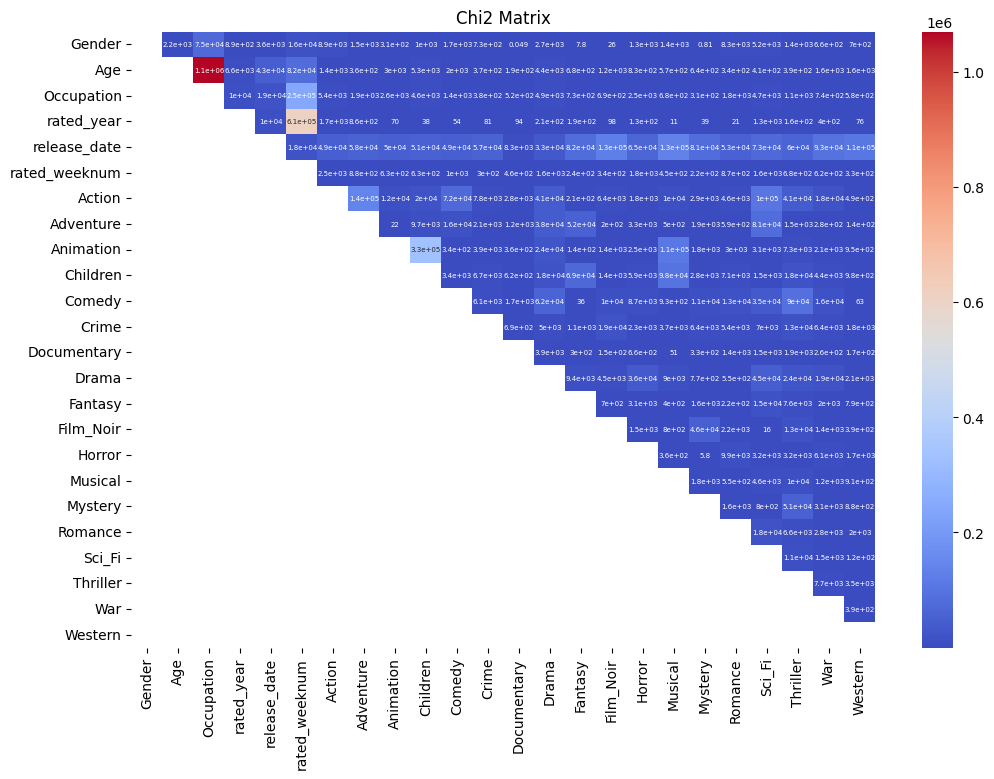

In [227]:
mask = np.tril(np.ones_like(chi2_df, dtype=bool))
plt.figure(figsize=(12,8))
sns.heatmap(chi2_df,mask=mask,annot=True,cmap='coolwarm',annot_kws={'size':5})
plt.title('Chi2 Matrix')
plt.show()

In [228]:
anova_df=pd.DataFrame([[0]*len(numerical_vars)]*len(categorical_vars),index=categorical_vars,columns=numerical_vars)

for col in numerical_vars:
    for col1 in range(len(categorical_vars)):
        print('=============== {}-{} ================\n'.format(col,categorical_vars[col1]),ratings_data.groupby([categorical_vars[col1]])[col].describe())
        print('\n')
        anova_df.loc[categorical_vars[col1],col],f=anova_lm_test(ratings_data,col,categorical_vars[col1])
    

=============== yrs_bet_release_and_rated-Gender ================
            count       mean        std  min  25%  50%   75%   max
Gender                                                           
F       246440.0  13.377305  14.903160  0.0  3.0  8.0  17.0  82.0
M       753769.0  13.445051  14.161373  0.0  3.0  8.0  18.0  82.0


                 sum_sq         df         F    PR(>F)
C(Gender)  8.523821e+02        1.0  4.140661  0.041865
Residual   2.058991e+08  1000207.0       NaN       NaN
There is a statistically significant difference between the mean yrs_bet_release_and_rated across the groups in Gender.
=============== yrs_bet_release_and_rated-Age ================
         count       mean        std  min  25%   50%   75%   max
Age                                                            
1     27211.0  11.264783  14.281971  0.0  2.0   5.0  14.0  80.0
18   183536.0  10.457687  12.355308  0.0  3.0   6.0  13.0  81.0
25   395556.0  12.159009  12.948707  0.0  3.0   8.0  16.0  82.

                       sum_sq         df             F  PR(>F)
C(release_date)  2.057224e+08       80.0  1.448046e+07     0.0
Residual         1.776090e+05  1000128.0           NaN     NaN
There is a statistically significant difference between the mean yrs_bet_release_and_rated across the groups in release_date.
=============== yrs_bet_release_and_rated-rated_weeknum ================
                   count       mean        std  min  25%   50%   75%   max
rated_weeknum                                                            
1                7594.0  13.846194  14.348902  1.0  4.0   8.0  18.0  80.0
2                5427.0  14.505067  15.419055  1.0  4.0   8.0  19.0  79.0
3                4432.0  12.019856  13.080970  1.0  4.0   7.0  15.0  81.0
4                4767.0  13.645270  14.452791  1.0  3.0   8.0  18.0  79.0
5                4046.0  12.473801  13.345302  1.0  4.0   8.0  16.0  79.0
6                2490.0  15.574699  15.415533  1.0  4.0  11.0  21.0  79.0
7                27

                sum_sq         df            F  PR(>F)
C(Crime)  5.864107e+05        1.0  2856.762371     0.0
Residual  2.053136e+08  1000207.0          NaN     NaN
There is a statistically significant difference between the mean yrs_bet_release_and_rated across the groups in Crime.
=============== yrs_bet_release_and_rated-Documentary ================
                 count       mean        std  min  25%  50%   75%   max
Documentary                                                           
0.0          992299.0  13.480431  14.382727  0.0  3.0  8.0  18.0  82.0
1.0            7910.0   6.896081   6.057408  0.0  3.0  6.0  11.0  70.0


                      sum_sq         df            F  PR(>F)
C(Documentary)  3.402155e+05        1.0  1655.410982     0.0
Residual        2.055598e+08  1000207.0          NaN     NaN
There is a statistically significant difference between the mean yrs_bet_release_and_rated across the groups in Documentary.
=============== yrs_bet_release_and_rated-Drama ==

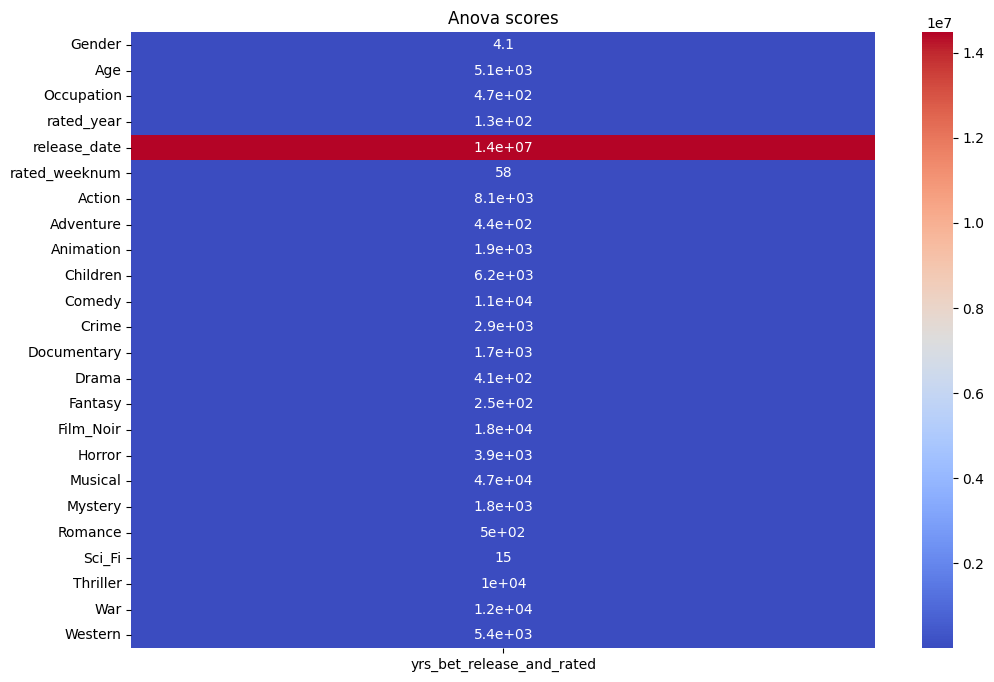

In [229]:
plt.figure(figsize=(12,8))
sns.heatmap(anova_df,annot=True,cmap='coolwarm',annot_kws={'size':10})
plt.title('Anova scores')
plt.show()

In [230]:
#dropping occupation as it has high correlation with age and lot of other categorical features
#dropping release_date

In [231]:

#per title 

##user wise timeseries of ratings behaviour change
##rated how many weeks/months after release

In [232]:
##Popular Movies in the data dump

pop_df=ratings_data.groupby(['Title']).agg(Rating=('Rating','mean'),Volume=('Rating','count')).reset_index()
alpha=0.5 ##importance level to Rating, Volume importance=1-alpha

popular_indexes=(((pop_df['Rating']-pop_df['Rating'].mean())/pop_df['Rating'].std())*alpha+\
((pop_df['Volume']-pop_df['Volume'].mean())/pop_df['Volume'].std())*(1-alpha)).sort_values(ascending=False)[:30].index

pop_df.loc[popular_indexes]

,Title,Rating,Volume
127,American Beauty (1999),4.317386,3428
3153,Star Wars: Episode IV - A New Hope (1977),4.453694,2991
3154,Star Wars: Episode V - The Empire Strikes Back...,4.292977,2990
3155,Star Wars: Episode VI - Return of the Jedi (1983),4.022893,2883
2894,Saving Private Ryan (1998),4.337354,2653
2711,Raiders of the Lost Ark (1981),4.477725,2514
2990,"Silence of the Lambs, The (1991)",4.351823,2578
2112,"Matrix, The (1999)",4.315830,2590
3015,"Sixth Sense, The (1999)",4.406263,2459
3293,Terminator 2: Judgment Day (1991),4.058513,2649


In [281]:
movies_data.columns

Index(['Movie ID', 'Title', 'Genres', 'release_date', 'Action', 'Adventure',
       'Animation', 'Children's', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance',
       'Sci-Fi', 'Thriller', 'War', 'Western'],
      dtype='object')

In [280]:
#ratings_data
##don't wanna train on 0s



,UserID,MovieID,Rating,Timestamp,rated_year,rated_weeknum,Gender,Age,Occupation,Title,Genres,release_date,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,yrs_bet_release_and_rated
0,1,1193,5,2001-01-01 03:42:40,2001,1,F,1,10,One Flew Over the Cuckoo's Nest (1975),Drama,1975,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26
1,1,661,3,2001-01-01 04:05:09,2001,1,F,1,10,James and the Giant Peach (1996),Animation|Children's|Musical,1996,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,1,914,3,2001-01-01 04:02:48,2001,1,F,1,10,My Fair Lady (1964),Musical|Romance,1964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,37
3,1,3408,4,2001-01-01 03:34:35,2001,1,F,1,10,Erin Brockovich (2000),Drama,2000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1,2355,5,2001-01-07 05:08:11,2001,1,F,1,10,"Bug's Life, A (1998)",Animation|Children's|Comedy,1998,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1091,1,2000-04-26 08:05:41,2000,17,M,25,6,Weekend at Bernie's (1989),Comedy,1989,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
1000205,6040,1094,5,2000-04-26 04:51:27,2000,17,M,25,6,"Crying Game, The (1992)",Drama|Romance|War,1992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,8
1000206,6040,562,5,2000-04-26 04:49:06,2000,17,M,25,6,Welcome to the Dollhouse (1995),Comedy|Drama,1995,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1000207,6040,1096,4,2000-04-26 07:50:48,2000,17,M,25,6,Sophie's Choice (1982),Drama,1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18


In [251]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix


user_item_matrix = ratings_data.groupby(['UserID','Title']).agg(Rating=('Rating','mean')).unstack().fillna(0)

# Apply SVD
svd = TruncatedSVD(n_components=20)
latent_matrix = svd.fit_transform(csr_matrix(user_item_matrix))



In [295]:
print('Sparsity of user-item matrix: '
      ,100*(user_item_matrix > 0).sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]),'%')

Sparsity of user-item matrix:  4.468362562231285 %


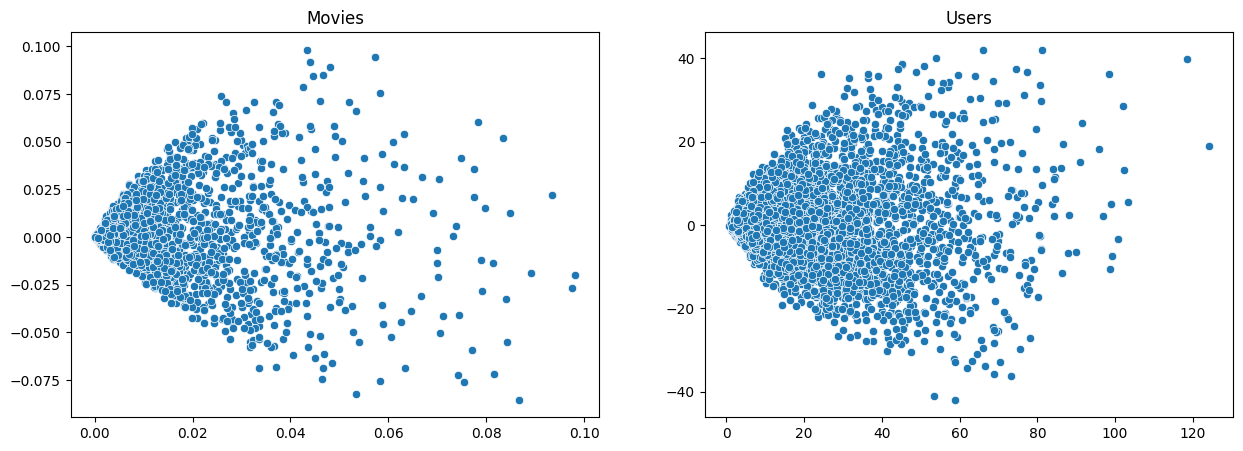

In [328]:
##visualize TSVD components
svd1 = TruncatedSVD(n_components=2)
latent_matrix1 = svd1.fit_transform(csr_matrix(user_item_matrix))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(x=svd1.components_.T[:, 0], y=svd1.components_.T[:, 1],  ax=axes[0], palette='viridis') #hue=labels,
axes[0].set_title('Movies')

sns.scatterplot(x=latent_matrix1[:, 0], y=latent_matrix1[:, 1],  ax=axes[1], palette='viridis') #hue=labels,
axes[1].set_title('Users')

plt.show()

In [340]:
from sklearn.metrics.pairwise import cosine_similarity

user_pearson_matrix=(pd.DataFrame(latent_matrix.T,columns=user_item_matrix.index)).corr(method='pearson')
user_pearson_matrix=pd.DataFrame(user_pearson_matrix,index=user_item_matrix.index,columns=user_item_matrix.index)
item_pearson_matrix=(pd.DataFrame(svd.components_,columns=[item[1] for item in user_item_matrix.columns])).corr(method='pearson')
item_pearson_matrix=pd.DataFrame(item_pearson_matrix,index=[item[1] for item in user_item_matrix.columns],columns=[item[1] for item in user_item_matrix.columns])

user_cosinesim_matrix=cosine_similarity(pd.DataFrame(latent_matrix,index=user_item_matrix.index))
user_cosinesim_matrix=pd.DataFrame(user_cosinesim_matrix,index=user_item_matrix.index,columns=user_item_matrix.index)
item_cosinesim_matrix=cosine_similarity(pd.DataFrame(svd.components_.T,index=[item[1] for item in user_item_matrix.columns]))
item_cosinesim_matrix=pd.DataFrame(item_cosinesim_matrix,index=[item[1] for item in user_item_matrix.columns],columns=[item[1] for item in user_item_matrix.columns])

In [ ]:
from cmfrec import CMF

model = CMF(k=20, method="als", niter=50, lambda_=0.1)

# Fit the model
model.fit(train_data)

# Get recommendations
user_id = 1
recommended_items = model.topN(user_id, N=10)
print("Top 10 recommendations for user {}:".format(user_id), recommended_items)


In [403]:
n_users=5
smooth_parameter=0.5
n_items=10

def agg_movies(x):
    movies=x[x>0].sort_values(ascending=False).droplevel(0).reset_index()
    movies.columns=['Title','rating']
    return movies



def check_random_user_recommendations(user_matrix,user_item_matrix,users=[],get_avg_metrics=False):
    if len(users)==0:
        users=np.random.choice(list(user_item_matrix.index.values),3)

    if get_avg_metrics:
        users=list(user_item_matrix.index.values)

    overlap=[]
    kprec=[]
    relevitems=[]

    for user in users:

        #picking n_users similar users
        similar_users=user_matrix[user].sort_values(ascending=False).iloc[1:n_users+1].index
        movies=user_item_matrix.loc[similar_users].apply(lambda x:agg_movies(x),axis=1)
        movies=pd.DataFrame(np.concatenate(movies.values),columns=['Title','rating'])
        movies=movies.groupby(['Title']).agg(rating=('rating','mean'),volume=('rating','count')).reset_index()

        popular_indexes=(((movies['rating']-movies['rating'].mean())/movies['rating'].std())*smooth_parameter+\
        ((movies['volume']-movies['volume'].mean())/movies['volume'].std())*(1-alpha)).sort_values(ascending=False)[:n_items].index

        movies=movies.loc[popular_indexes].reset_index(drop=True)

        movies_from_user=user_item_matrix.loc[user]
        movies_from_user=movies_from_user[movies_from_user>0].droplevel(0).sort_values(ascending=False)

        movies['user_rating']=np.nan
        for idx,row in movies.iterrows():
            try:
                movies.loc[idx,'user_rating']=movies_from_user[row.Title]
            except:
                pass


        movies_from_user=list(movies_from_user.index[:n_items])
        valid_recs=(~(movies.user_rating.isna())).sum()
        overlaps=len(set(movies.loc[(~(movies.user_rating.isna())),'Title'].values).intersection(movies_from_user))

        K_prec_user_mat=user_item_matrix.loc[user]
        K_prec_user_mat=K_prec_user_mat[K_prec_user_mat>=4].droplevel(0).sort_values(ascending=False).index
        K_precision=len(set(movies.loc[(~(movies.user_rating.isna())),'Title'].values).intersection(K_prec_user_mat))
        if valid_recs==0:
            avg_perc_overlap=0
            avg_k_precision=0
        else:
            avg_perc_overlap=overlaps/valid_recs
            avg_k_precision=K_precision/valid_recs

        if len(K_prec_user_mat)==0:
            avg_relevant_items_matched=0
        else:
            avg_relevant_items_matched=K_precision/len(K_prec_user_mat)

        overlap.append(avg_perc_overlap)
        kprec.append(avg_k_precision)
        relevitems.append(avg_relevant_items_matched)
        if not get_avg_metrics:
            print('==============================\nUserID: ',user)
            print('\nperc_overlap: {}\nK_precision: {}\nrelevant_items_matched: {}'.format(avg_perc_overlap,avg_k_precision,avg_relevant_items_matched))

            movies['Neighbors_mean_rating/Volume']=movies.rating.astype(float).round(2).astype(str)+'/'+movies.volume.round(0).astype(str)
            movies.drop(['rating','volume'],axis=1,inplace=True)
            movies.columns=['Recommended Movies','User_Rating','Neighbors_mean_rating/Volume']
            table = BeautifulTable()
            for ind,row in movies.iterrows():
                table.rows.append(row)
            table.columns.header = movies.columns
            print(table)
            return -1,-1,-1
    return overlap,kprec,relevitems


def check_random_item_recommendation(item_matrix,user_item_matrix,users=[],get_avg_metrics=False):
    item_user_matrix=user_item_matrix.T.droplevel(0)
    if len(users)==0:
        users=np.random.choice(list(user_item_matrix.index.values),3)

    if get_avg_metrics:
        users=list(user_item_matrix.index.values)

    overlap=[]
    kprec=[]
    relevitems=[]

    for user in users:
        user_items = user_item_matrix.loc[user]
        user_items = user_items[user_items >=4].droplevel(0).sort_values(ascending=False) ##recommendations based on liked movies

        recommended_items =pd.DataFrame()

        for item in user_items.index:
            # similar items
            similar_items = item_matrix[item].sort_values(ascending=False).iloc[1:n_items+1]
            similar_items=item_user_matrix.loc[similar_items.index].apply(lambda x:pd.Series([x[x>0].mean(),x[x>0].count()]),axis=1).reset_index()
            similar_items.columns=['Recommended_Movie','Avg_Rating','Volume']
            similar_items['user_rating']=np.nan
            similar_items['user_movie']=item
            for idx,row in similar_items.iterrows():
                try:
                    similar_items.loc[idx,'user_rating']=item_user_matrix.loc[row.Recommended_Movie,user]
                except:
                    pass

            recommended_items=pd.concat([recommended_items,similar_items],axis=0,ignore_index=True)

        
        #print(recommended_items.shape)
        try:
            r1=recommended_items.groupby(['Recommended_Movie','Avg_Rating','Volume','user_rating']).apply(lambda x:list(x.user_movie.values)).reset_index()
            r2=recommended_items.groupby(['Recommended_Movie','Avg_Rating','Volume','user_rating']).user_movie.count().reset_index()
            r1.columns=['Recommended_Movie','Avg_Rating','Volume','user_rating','user_movies']
            r2.columns=['Recommended_Movie','Avg_Rating','Volume','user_rating','num_time_recommended']
            r1=r1.merge(r2,how='left',on=['Recommended_Movie','Avg_Rating','Volume','user_rating'])

            popular_indexes=(((r1['Avg_Rating']-r1['Avg_Rating'].mean())/r1['Avg_Rating'].std())*smooth_parameter+\
            ((r1['Volume']-r1['Volume'].mean())/r1['Volume'].std())*(1-alpha)).sort_values(ascending=False)[:n_items].index

            r1=r1.loc[popular_indexes].reset_index(drop=True)

            movies_from_user=user_item_matrix.loc[user]
            movies_from_user=movies_from_user[movies_from_user>0].droplevel(0).sort_values(ascending=False)
            movies_from_user=list(movies_from_user.index[:n_items])

            valid_recs=(~(r1.user_rating==0)).sum()
            overlaps=len(set(r1.loc[(~(r1.user_rating==0)),'Recommended_Movie'].values).intersection(movies_from_user))

            K_prec_user_mat=user_item_matrix.loc[user]
            K_prec_user_mat=K_prec_user_mat[K_prec_user_mat>=4].droplevel(0).sort_values(ascending=False).index
            K_precision=len(set(r1.loc[(~(r1.user_rating==0)),'Recommended_Movie'].values).intersection(K_prec_user_mat))
            if valid_recs==0:
                avg_perc_overlap=0
                avg_k_precision=0
            else:
                avg_perc_overlap=overlaps/valid_recs
                avg_k_precision=K_precision/valid_recs

            if len(K_prec_user_mat)==0:
                avg_relevant_items_matched=0
            else:
                avg_relevant_items_matched=K_precision/len(K_prec_user_mat)

            overlap.append(avg_perc_overlap)
            kprec.append(avg_k_precision)
            relevitems.append(avg_relevant_items_matched)
        except:
            overlap.append(0)
            kprec.append(0)
            relevitems.append(0)
        if not get_avg_metrics:
            print('==============================\nUserID: ',user)
            print('\nperc_overlap: {}\nK_precision: {}\nrelevant_items_matched: {}'.format(avg_perc_overlap
                                                                                           ,avg_k_precision
                                                                                          ,avg_relevant_items_matched))

            table = BeautifulTable()
            for ind,row in r1.iterrows():
                table.rows.append(row)
            table.columns.header = r1.columns
            print(table)
            return -1,-1,-1
    return overlap,kprec,relevitems

def plott(overlap,kprec,relevitems):
    plt.figure(figsize=(12, 6))

    print('avg % overlap:',np.mean(np.array(overlap)))
    print('avg K-Precision:',np.mean(np.array(kprec)))
    print('avg relevant items matched:',np.mean(np.array(relevitems)))
    sns.kdeplot(np.array(overlap), label='{}'.format('overlap'), palette='viridis')
    sns.kdeplot(np.array(kprec), label='{}'.format('K-Precision'), palette='viridis')
    sns.kdeplot(np.array(relevitems), label='{}'.format('relevant items matched'), palette='viridis')

    plt.title('Distribution Plot')
    plt.xlabel('% overlap/K-Precision/relevant items matched')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()




In [ ]:
print('===============================================\nDemonstration from user-user method using pearson correlation\n')
check_random_user_recommendations(user_pearson_matrix,user_item_matrix,[])
overlap,kprec,relevitems=check_random_user_recommendations(user_pearson_matrix,user_item_matrix,[],True)
plott(overlap,kprec,relevitems)

print('===============================================\nDemonstration from user-user method using cosine similarity\n')
check_random_user_recommendations(user_cosinesim_matrix,user_item_matrix,[])
overlap,kprec,relevitems=check_random_user_recommendations(user_cosinesim_matrix,user_item_matrix,[],True)
plott(overlap,kprec,relevitems)



In [404]:
print('===============================================\nDemonstration from item-item method using cosine similarity\n')
check_random_item_recommendation(item_cosinesim_matrix,user_item_matrix,[])
overlap,kprec,relevitems=check_random_item_recommendation(item_cosinesim_matrix,user_item_matrix,[],True)
plott(overlap,kprec,relevitems)


print('===============================================\nDemonstration from item-item method using pearson correlation\n')
check_random_item_recommendation(item_pearson_matrix,user_item_matrix,users=[])
overlap,kprec,relevitems=check_random_item_recommendation(item_pearson_matrix,user_item_matrix,[],True)
plott(overlap,kprec,relevitems)

Demonstration from item-item method using cosine similarity

UserID:  3184

perc_overlap: 0.0
K_precision: 1.0
relevant_items_matched: 0.05333333333333334
+------------+------------+--------+-----+------------------------------+------+
| Recommende | Avg_Rating | Volume | use |         user_movies          | num_ |
|  d_Movie   |            |        | r_r |                              | time |
|            |            |        | ati |                              | _rec |
|            |            |        | ng  |                              | omme |
|            |            |        |     |                              | nded |
+------------+------------+--------+-----+------------------------------+------+
| American B |   4.317    | 3428.0 | 5.0 | ['Being John Malkovich (1999 |  1   |
| eauty (199 |            |        |     |             )']              |      |
|     9)     |            |        |     |                              |      |
+------------+------------+--------

KeyboardInterrupt: 

<span style="font-size: 18px;"><b>=========== Supervised Modelling ============</b></span>

In [ ]:
##cant capture latent patterns
##doesnt account for movies and users that don't cooccur


In [ ]:
##rather make a regression model

In [282]:
def train_test(dd,x_cols,y_col,stratify_col=None):
    d=dd.copy()
    d=d.sample(frac=1,random_state=0).reset_index(drop=True)
    xtrain,xtest,ytrain,ytest=train_test_split(d.loc[:,x_cols]
                                               ,d.loc[:,y_col]
                                               ,test_size=0.1  #10% test_size
                                               ,random_state=0,stratify=stratify_col) 
    return xtrain,xtest,ytrain,ytest


##Standardize

def filter_numeric(data,coll):
    enum_coll=list(enumerate(coll))
    cols=data.select_dtypes(include=['number']).columns
    cc=[]
    for col in cols:
        if (data[col].nunique()>2) or\
        ((sorted(list(data[col].unique()))!=[0,1]) and\
        (sorted(list(data[col].unique()))!=[0]) and\
        (sorted(list(data[col].unique()))!=[1])):
            cc.append(col)
        
    cols=cc
    numeric_cols=list(set(cols).intersection(set(coll)))
    li=[sett[1] for sett in enum_coll if sett[1] in numeric_cols]
    return li
    
def standardize_data(d,cols,strategy='standard'):
    if strategy=='standard':
        scalar=StandardScaler()   
    else:
        scalar=MinMaxScaler()
    data=d.copy()
    cols=filter_numeric(data,cols)
    data.loc[:,cols]=pd.DataFrame(scalar.fit_transform(data[cols]),columns=cols,index=data.index)
    
    return data,scalar,cols

def transform_standardize_data(d,cols,scalar):
    data=d.copy()
    data.loc[:,cols]=pd.DataFrame(scalar.transform(data[cols]),columns=cols,index=data.index)
    return data

def revtransform_standardize_data(d,cols,scalar):
    data=d.copy()
    data.loc[:,cols]=pd.DataFrame(scalar.inverse_transform(data[cols]),columns=cols,index=data.index)
    return data

## One hot encoding
def dummy_str_col(d,cols):
    data=d.copy()
    drop_str_cols=[]
    str_cols=cols
    for str_col in str_cols:
        str_data=pd.get_dummies(data.loc[:,str_col]).astype(int)
        str_data.columns=[str_col+'_'+str(col) for col in str_data.columns]
        drop_str_cols.append(str_data.columns[-1])
        str_data.drop(str_data.columns[-1],axis=1,inplace=True)
    
        data.drop(str_col,axis=1,inplace=True)
        data=pd.concat([data,str_data],axis=1)
    return data,drop_str_cols

def test_str_col(d,cols,drop_str_cols):
    data=d.copy()
    str_cols=cols
    for str_col in str_cols:
        str_data=pd.get_dummies(data.loc[:,str_col]).astype(int)
        str_data.columns=[str_col+'_'+str(col) for col in str_data.columns]
        data.drop(str_col,axis=1,inplace=True)
        data=pd.concat([data,str_data],axis=1)

    for drop_col in drop_str_cols:
        data.drop(drop_col,axis=1,inplace=True)
        
    return data

In [283]:

# trying it out with occupation and then without occupation
one_hot_cols=['rated_year','rated_weeknum','Gender','Age'] #,'Occupation'



In [284]:
cleaned_df=ratings_data.copy()

cleaned_df.drop(['UserID','Occupation','MovieID','Timestamp','Title','Genres','release_date'],axis=1,inplace=True)

cleaned_df,drop_str_cols=dummy_str_col(cleaned_df,one_hot_cols)

stratify_col=ratings_data.Rating.astype(str)
for cat in categorical_vars:
    if cat in('Gender','Age','Occupation','rated_year','rated_weeknum','release_date'
             ,'Comedy','Drama','Action','Thriller'):   ##most volume from comedy and drama
        continue
    stratify_col=stratify_col+ratings_data[cat].astype(str)

xtrain,xtest,ytrain,ytest=train_test(cleaned_df,[col for col in cleaned_df if col!='Rating'],'Rating',stratify_col)  

xtrain.reset_index(drop=True,inplace=True)
xtest.reset_index(drop=True,inplace=True)
ytrain.reset_index(drop=True,inplace=True)
ytest.reset_index(drop=True,inplace=True)

In [285]:
xtrain_std,scalar,numeric_cols=standardize_data(xtrain,xtrain.columns)
xtest_std=transform_standardize_data(xtest,numeric_cols,scalar)

In [382]:
user_cols

NameError: name 'user_cols' is not defined

In [385]:
cleaned_df1

,UserID,Rating,rated_year,rated_weeknum,Gender,Age,Title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,yrs_bet_release_and_rated
0,1,5,2001,1,F,1,One Flew Over the Cuckoo's Nest (1975),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26
1,1,3,2001,1,F,1,James and the Giant Peach (1996),0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,1,3,2001,1,F,1,My Fair Lady (1964),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,37
3,1,4,2001,1,F,1,Erin Brockovich (2000),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,1,5,2001,1,F,1,"Bug's Life, A (1998)",0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000204,6040,1,2000,17,M,25,Weekend at Bernie's (1989),0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
1000205,6040,5,2000,17,M,25,"Crying Game, The (1992)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,8
1000206,6040,5,2000,17,M,25,Welcome to the Dollhouse (1995),0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1000207,6040,4,2000,17,M,25,Sophie's Choice (1982),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18


In [395]:
cleaned_df1=ratings_data.copy()
cleaned_df1.drop(['MovieID','Occupation','Timestamp','Genres'],axis=1,inplace=True)

user_cols=['UserID','Gender', 'Age']
user_factors=cleaned_df1[user_cols].copy().drop_duplicates(keep='first').set_index('UserID')
user_factors,drop_str_cols=dummy_str_col(user_factors,user_factors.columns)

movie_cols=['Title', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film_Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci_Fi', 'Thriller', 'War', 'Western','release_date']

movie_factors=cleaned_df1[movie_cols].copy().drop_duplicates(keep='first').set_index('Title')
movie_factors,drop_str_cols=dummy_str_col(movie_factors,['release_date'])

stratify_col=ratings_data.Rating.astype(str)
for cat in categorical_vars:
    if cat in('Gender','Age','Occupation','rated_year','rated_weeknum','release_date'
             ,'Comedy','Drama','Action','Thriller'):   ##most volume from comedy and drama
        continue
    stratify_col=stratify_col+ratings_data[cat].astype(str)

xtrain,xtest,ytrain,ytest=train_test(cleaned_df1,[col for col in cleaned_df1 if col!='Rating'],'Rating',stratify_col)  

xtrain.reset_index(drop=True,inplace=True)
xtest.reset_index(drop=True,inplace=True)
ytrain.reset_index(drop=True,inplace=True)
ytest.reset_index(drop=True,inplace=True)

train_df=pd.concat([xtrain,ytrain],axis=1)
test_df=pd.concat([xtest,ytest],axis=1)

train_matrix = train_df.pivot(index='UserID', columns='Title', values='Rating').fillna(0).values
train_rating_year_matrix = train_df.pivot(index='UserID', columns='Title', values='rated_year').fillna(0).values.astype(np.float32)

test_matrix = test_df.pivot(index='UserID', columns='Title', values='Rating').fillna(0).values
test_rating_year_matrix = test_df.pivot(index='UserID', columns='Title', values='rated_year').fillna(0).values.astype(np.float32)


In [397]:
train_df

,UserID,rated_year,rated_weeknum,Gender,Age,Title,release_date,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,yrs_bet_release_and_rated,Rating
438723,1130,2000,52,M,18,Planet of the Apes (1968),1968,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,32,4
708044,1421,2000,47,F,1,"Mask, The (1994)",1994,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,3
11922,3128,2001,10,M,18,Austin Powers: International Man of Mystery (1...,1997,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5
744858,4446,2000,31,M,18,Better Than Chocolate (1999),1999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,4
942671,5728,2000,20,F,35,Romancing the Stone (1984),1984,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664551,5625,2000,21,M,25,Reservoir Dogs (1992),1992,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,5
519600,2630,2000,45,F,18,"Talented Mr. Ripley, The (1999)",1999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,4
14083,3638,2000,33,M,25,E.T. the Extra-Terrestrial (1982),1982,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,18,4
601135,2533,2000,46,F,25,Addicted to Love (1997),1997,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,3


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [392]:
model = CMF(
    k=2,  
    user_factors=True,  # Include user factors
    item_factors=True,  # Include item factors
    user_bias=True,  # Include user biases
    item_bias=True,  # Include item biases
    global_bias=True,  # Include global bias
    add_implicit=True,  # Add implicit feedback
    add_temporal=True,  # Add temporal dynamics
    user_side_info=user_factors,  # User features (age, occupation)
    item_side_info=movie_factors,  # Item features (release year)
    temporal_matrix=train_rating_year_matrix,  # Temporal feature matrix
    maxiter=100,  # Maximum iterations
    verbose=True  # Print progress
)


model.fit(train_matrix)


def evaluate_model(data_df, rating_year_matrix, model):
    predictions = []
    for index, row in data_df.iterrows():
        user_id = row['UserID']
        movie_id = row['Title']
        true_rating = row['Rating']
        
        temporal_feature = rating_year_matrix[data_df.index.get_loc(index)]
        
        predicted_rating = model.predict(user=user_id, item=movie_id,temporal_feature=temporal_feature)
        predictions.append((true_rating, predicted_rating))

    # predictions to a DataFrame
    predictions_df = pd.DataFrame(predictions, columns=['true_rating', 'predicted_rating'])

    # evaluation metrics
    mape = np.mean(np.abs((predictions_df['true_rating'] - predictions_df['predicted_rating']) / predictions_df['true_rating'])) * 100
    rmse = np.sqrt(np.mean((predictions_df['true_rating'] - predictions_df['predicted_rating']) ** 2))
    mse = np.mean((predictions_df['true_rating'] - predictions_df['predicted_rating']) ** 2)

    return mape, rmse, mse

train_mape, train_rmse, train_mse = evaluate_model(train_df, train_rating_year_matrix, model)
print(f"Training Set - MAPE: {train_mape:.2f}%, RMSE: {train_rmse:.4f}, MSE: {train_mse:.4f}")

# Evaluate on test set
test_mape, test_rmse, test_mse = evaluate_model(test_df, test_rating_year_matrix, model)
print(f"Test Set - MAPE: {test_mape:.2f}%, RMSE: {test_rmse:.4f}, MSE: {test_mse:.4f}")

,UserID,rated_year,rated_weeknum,Gender,Age,Title,release_date,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,yrs_bet_release_and_rated,Rating
438723,1130,2000,52,M,18,Planet of the Apes (1968),1968,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,32,4
708044,1421,2000,47,F,1,"Mask, The (1994)",1994,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,3
11922,3128,2001,10,M,18,Austin Powers: International Man of Mystery (1...,1997,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5
744858,4446,2000,31,M,18,Better Than Chocolate (1999),1999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,4
942671,5728,2000,20,F,35,Romancing the Stone (1984),1984,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664551,5625,2000,21,M,25,Reservoir Dogs (1992),1992,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,8,5
519600,2630,2000,45,F,18,"Talented Mr. Ripley, The (1999)",1999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1,4
14083,3638,2000,33,M,25,E.T. the Extra-Terrestrial (1982),1982,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,18,4
601135,2533,2000,46,F,25,Addicted to Love (1997),1997,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3,3


In [393]:
user_factors = model.user_factors_
item_factors = model.item_factors_

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Movies (Items)
sns.scatterplot(x=item_factors[:, 0], y=item_factors[:, 1], ax=axes[0], palette='viridis')
axes[0].set_title('Movies')
axes[0].set_xlabel('Latent Factor 1')
axes[0].set_ylabel('Latent Factor 2')

# Users
sns.scatterplot(x=user_factors[:, 0], y=user_factors[:, 1], ax=axes[1], palette='viridis')
axes[1].set_title('Users')
axes[1].set_xlabel('Latent Factor 1')
axes[1].set_ylabel('Latent Factor 2')

plt.tight_layout()
plt.show()

,UserID,rated_year,rated_weeknum,Gender,Age,Title,release_date,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film_Noir,Horror,Musical,Mystery,Romance,Sci_Fi,Thriller,War,Western,yrs_bet_release_and_rated,Rating
82787,4621,2000,29,M,25,Independence Day (ID4) (1996),1996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,4,2
329389,272,2000,50,M,18,"Edge, The (1997)",1997,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3
501097,3519,2000,39,F,25,Good Will Hunting (1997),1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,4
220578,293,2000,50,M,56,Bull Durham (1988),1988,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12,5
620836,1142,2000,47,M,18,"Blair Witch Project, The (1999)",1999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694433,3376,2000,35,M,35,Being John Malkovich (1999),1999,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,3
54414,2537,2000,45,M,35,Mary Poppins (1964),1964,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,36,3
690157,1272,2000,47,M,18,Mrs. Doubtfire (1993),1993,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,4
924668,3921,2000,32,M,25,That Thing You Do! (1996),1996,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4


In [286]:
#xtest_std

In [291]:
def itertool_comb(params,estimator_pkl,key_to_ignore=['regressor','classifier']):
    param_list=[]
    for param in params:
        estimator=[value[0] for key,value in param.items() if key in key_to_ignore]
        keys=[key.split('__')[1] for key,value in param.items() if key not in key_to_ignore]
        values=[value for key,value in param.items() if key not in key_to_ignore]
        values=list(product(*values))
        iter_list=[]
        for i in range(len(values)):
            iter_dict=dict()
            for j in range(len(values[i])):
                iter_dict[keys[j]]=values[i][j]
            iter_list.append([estimator[0],iter_dict])
        for l in iter_list:
            param_list.append(l)

    par_dict={
        'param_grid':param_list,
        'checkpoint_index':0,  ##from param_list
        'best_param_index':None,
        'best_estimator':None,

        'best_val_mse': float('inf'),
        'best_val_mape': float('inf'),
        'best_val_rmse': float('inf'),

        'scaler':None
    }

    pickle.dump(par_dict,open(estimator_pkl,'wb'))


def accuracy_checks(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f'MSE: {mse}\nRMSE: {rmse}\nMAPE: {mape}')
    return mse, rmse, mape

def training(xtrain, ytrain, estimator_pkl, n_splits=5):

    param_dict = pickle.load(open(estimator_pkl, 'rb'))
    param_grid = param_dict['param_grid']
    checkpoint_index = param_dict['checkpoint_index']  ##one already covered
    best_param_index = param_dict['best_param_index']

    best_val_mse = param_dict['best_val_mse']
    best_val_rmse = param_dict['best_val_rmse']
    best_val_mape = param_dict['best_val_mape']

    ind = checkpoint_index if checkpoint_index != 0 else 0

    while ind < len(param_grid):
        start_time = time.time()
        estimator = param_grid[ind][0]
        parameters = param_grid[ind][1]
        estimator.set_params(**parameters)

        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
        #smote = SMOTE(random_state=42)

        stratify_col=ytrain.astype(str)

        fold = 0
        mses = []
        rmses = []
        mapes = []

        print(f'Iteration: {ind + 1}')
        print(str(estimator))
        print('=========================Training in Folds===========================')
        for train_index, test_index in skf.split(xtrain, stratify_col):
            fold += 1
            print(f'============Fold {fold}=============')
            X_train, X_val = xtrain.iloc[train_index], xtrain.iloc[test_index]
            y_train, y_val = ytrain.iloc[train_index], ytrain.iloc[test_index]

            X_train_resampled, y_train_resampled = X_train.copy(), y_train.copy() #smote.fit_resample(X_train, y_train)

            estimator.fit(X_train_resampled, y_train_resampled)
            y_pred_val = estimator.predict(X_val)
            
            print('==========================Val metrics================================')
            val_mse, val_rmse, val_mape = accuracy_checks(y_val, y_pred_val)

            mses.append(val_mse)
            rmses.append(val_rmse)
            mapes.append(val_mape)

        print('==========================End of Folds================================')
        mse = np.mean(mses)
        rmse = np.mean(rmses)
        mape = np.mean(mapes)

        if mse < best_val_mse:
            param_dict['best_param_index'] = ind
            param_dict['best_estimator'] = deepcopy(estimator)

            param_dict['best_val_mse'] = mse
            param_dict['best_val_rmse'] = rmse
            param_dict['best_val_mape'] = mape

        param_dict['checkpoint_index'] = ind
        print('========================================================================')
        print('time taken(mins): ', (time.time() - start_time) / 60)
        print("param_dict[best_estimator]: ", param_dict['best_estimator'])
        print("param_dict[best_val_mse]: ", param_dict['best_val_mse'])
        print("param_dict[best_val_rmse]: ", param_dict['best_val_rmse'])
        print("param_dict[best_val_mape]: ", param_dict['best_val_mape'])
        print('========================================================================')

        pickle.dump(param_dict, open(estimator_pkl, 'wb'))

        ind += 1

def find_best_model(estimator_pkl, xtrain, ytrain, xtest, ytest, n_splits, is_first):

    ##creating pickle file first time
    if is_first:
        itertool_comb(param, estimator_pkl)

    training(xtrain, ytrain, estimator_pkl, n_splits)
    
#from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb

param = [
    {
        'classifier': [xgb.XGBRegressor()],
        'classifier__n_estimators': [100],
        'classifier__learning_rate': [0.01, 0.05],
        'classifier__max_depth': [5],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0],
        'classifier__eval_metric': ['rmse']  # Note: Multi-class log-loss for XGBoost
    }
]

estimator_pkl = 'best_estimator.pkl'

find_best_model(estimator_pkl, xtrain, ytrain, xtest, ytest, 5, True)

Iteration: 1
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...)
=========================Training in Folds===========================
============Fold 1=============
==========================Val metrics================================
MSE: 2.4443928230954675
RMSE: 1.5634554112911143
MAPE: 0.3932085169560259
============F

Iteration: 4
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
=========================Training in Folds===========================
============Fold 1=============
==========================Val metrics================================
MSE: 2.4407910030569977
RMSE: 1.5623031085730443
MAPE: 0.3923623334908936
============Fold 2=============
=======================

Iteration: 7
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.8,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
=========================Training in Folds===========================
============Fold 1=============
==========================Val metrics================================
MSE: 1.1236056727765331
RMSE: 1.06000267583461
MAPE: 0.35132532859186966
============Fold 2=============
========================

MSE: 1.1204051052927613
RMSE: 1.058491901382699
MAPE: 0.3498782924932097
Feature importances:


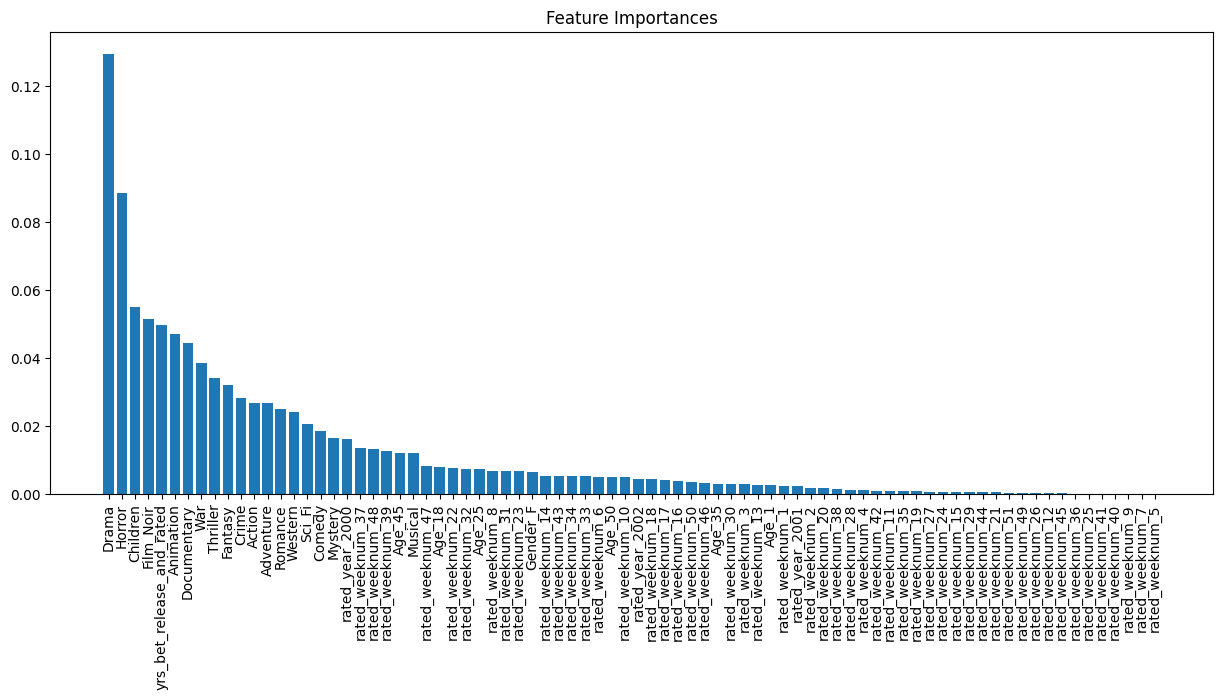

In [293]:
param_dict=pickle.load(open(estimator_pkl,'rb'))
estimator=param_dict['best_estimator']

y_pred_test = estimator.predict(xtest)

mse, rmse, mape = accuracy_checks(ytest, y_pred_test)


if hasattr(estimator, 'feature_importances_'):
    importances = estimator.feature_importances_
    print("Feature importances:")
elif hasattr(estimator, 'coef_'):
    importances = estimator.coef_
    print("Model coefficients:")
    print(importances)
else:
    print("The best regressor does not provide feature importances or coefficients.")

# Optional: visualize feature importances if available
if 'importances' in locals():
    feature_names = xtrain.columns if hasattr(xtrain, 'columns') else np.arange(xtrain.shape[1])
    sorted_indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(15, 6))
    plt.bar(range(len(importances)), importances[sorted_indices], align='center')
    plt.xticks(range(len(importances)), feature_names[sorted_indices], rotation=90)
    plt.title('Feature Importances')
    plt.show()